# Spike Gadgets Ephys and Video Syncing

# TODO

- [] Refactor the trodes extraction functions

In [1]:
import os
import re
import sys
from collections import defaultdict
import random
from random import randrange
import glob
import warnings

In [2]:
import numpy as np
import pandas as pd
# import cv2
from IPython.display import Video
import matplotlib.pyplot as plt

In [3]:
# setting path
sys.path.append('../../src')

In [4]:
import trodes.read_exported

In [5]:
%matplotlib inline

In [6]:
import spikeinterface

In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_216485/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [8]:
import spikeinterface.core

In [9]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [10]:
import spikeinterface.full as si

# Part 0: Index of all the column names

raw directory
- raw_group0.dat
    - voltage_value: Array with voltage measurement for each channel at each timestamp
- timestamps.dat
    - voltage_time_stamp: The time stamp of each voltage measurement

parent directory
- 1.videoTimeStamps.cameraHWSync
    - frame_number: Calculated by getting the index of each video time stamp tuple 
    - PosTimestamp: The time stamp of each video frame
    - HWframeCount: Unknown value. Starts at 30742 and increases by 1 for each tuple  
    - HWTimestamp: Unknown value. All zeroes
    - video_time: Calculated by dividing the frame number by the fps(frames per second) 
    - video_seconds: video_time, but rounded to seconds  	
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_PosTimestamp 	
        - filledHWframeCount 	
        - filled_frame_number 	
        - filled_video_time 	
        - filled_video_seconds 	

DIO directory
- dio_ECU_Din1.dat
    - time: The time stamp the corresponds to the DIN input
    - state: Binary state of whether there is input from DIN or not 	
    - trial_number: Calculated by adding 1 to every time there is a DIN input
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_state 	
        - filled_trial_number

ss_output directory (Spike sorting with Spike interface)
- firings.npz
    - unit_id: All the units that had a spike train for the given timestamp 	
    - number_of_units: Calculated by counting the number of units that had a spike train

# Part 1: Inputting Data

## Name of protocol for naming

- This name will be used to name files and title plots. Please change if you are using a different protocol or adding more details
    - **NOTE**: This should be changed based on the name the protocol

In [11]:
protocol_name = "tethered_with_medpc"

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [12]:
input_folder = "./data"

In [13]:
# Accomodates for both capitalization of the file names
raw_data_file_keyword = '*[mM]edpc*'

- Asking the user what the path to the recording files are, with the option of using wildcards

- Make this cell into non-code block if you are using the same file path for multiple runs

In [14]:
raw_data_glob_pattern = "./data/20221122_161341_omission_subject_6_1_and_6_3.rec"

- By default, this will search for files that are in the `./data` folder (in the folder that this notebook is in) that have key word you specified in the file name

In [15]:
# Using the user inputted path/pattern
if raw_data_glob_pattern.strip():
    # Getting a list of all matching files
    raw_data_files_list = glob.glob(raw_data_glob_pattern.strip())
    # Checking if there were any files that matched
    if raw_data_files_list:
        raw_data_file_path = raw_data_files_list[0]
    else:
        raise ValueError("No files were found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))

# Using the default pattern
else:
    # Searching for matching files with recursion
    if glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword)):
        raw_data_glob_pattern = os.path.join(input_folder + "**", raw_data_file_keyword)
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    # Searching for matching files only in the specified folder
    elif glob.glob(os.path.join(input_folder, raw_data_file_keyword)):
        raw_data_glob_pattern = glob.glob(os.path.join(input_folder, raw_data_file_keyword))
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    else:
        raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))


- Checking to see if only one file is specified

In [16]:
if len(raw_data_files_list) >= 2:
    raise ValueError("More than one file was found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))
else:
    # Using the first(and only file) as the file path
    raw_data_file_path = raw_data_files_list[0]

In [17]:
raw_data_file_path

'./data/20221122_161341_omission_subject_6_1_and_6_3.rec'

## Extracting the data and the metadata from the Recording folder

- Creating a dictionary that has the directory as the key and a dictionary that has the file name as the key and the 

In [18]:
file_to_data = trodes.read_exported.get_all_trodes_data_from_directory(raw_data_file_path)

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:70: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject_6_1_and_6_3.rec/20221122_161341_omission_subject_6_1_top_4_base_2.rec
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2

file prefix: 1.videoTimeStamps.cameraHWSync
directory prefix: .
file prefix: 1.videoTimeStamps.cameraHWSync
directory prefix: .
file prefix: 1.videoTimeStamps.cameraHWSync
directory prefix: .
file prefix: LFP_nt15ch1.dat
directory prefix: LFP
file prefix: LFP_nt16ch1.dat
directory prefix: LFP
file prefix: LFP_nt7ch1.dat
directory prefix: LFP
file prefix: LFP_nt5ch1.dat
directory prefix: LFP
file prefix: LFP_nt2ch1.dat
directory prefix: LFP
file prefix: LFP_nt17ch1.dat
directory prefix: LFP
file prefix: LFP_nt9ch1.dat
directory prefix: LFP
file prefix: LFP_nt13ch1.dat
directory prefix: LFP
file prefix: LFP_nt6ch1.dat
directory prefix: LFP
file prefix: LFP_nt14ch1.dat
directory prefix: LFP
file prefix: LFP_nt19ch1.dat
directory prefix: LFP
file prefix: LFP_nt23ch1.dat
directory prefix: LFP
file prefix: LFP_nt11ch1.dat
directory prefix: LFP
file prefix: LFP_nt20ch1.dat
directory prefix: LFP
file prefix: LFP_nt32ch1.dat
directory prefix: LFP
file prefix: LFP_nt31ch1.dat
directory prefix: L

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject_6_1_and_6_3.rec/old/20221122_161341_omission_subject_6_3_top_1_base_3.trodesconf
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject_6_1_and_6_3.rec/old/20221122_161341_omission_subject_6_1_t

file prefix: spikeband_nt29ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt12ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt14ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt25ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt16ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt1ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt26ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt11ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt7ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt18ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt31ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt4ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt22ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt15ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt6ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt30ch1.dat
directory prefix: spikeb

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject_6_1_and_6_3.rec/20221122_161341_omission_subject_6_3_top_1_base_3.kilosort/20221122_161341_omission_subject_6_3_top_1_base_3.group0.dat
  warnings.warn("Can not process {}".format(absolute_file_path))


file prefix: raw_group0.dat
directory prefix: raw
file prefix: timestamps.dat
directory prefix: raw
file prefix: spikes_nt19.dat
directory prefix: spikes
file prefix: spikes_nt10.dat
directory prefix: spikes
file prefix: spikes_nt15.dat
directory prefix: spikes
file prefix: spikes_nt32.dat
directory prefix: spikes
file prefix: spikes_nt14.dat
directory prefix: spikes
file prefix: spikes_nt24.dat
directory prefix: spikes
file prefix: spikes_nt17.dat
directory prefix: spikes
file prefix: spikes_nt18.dat
directory prefix: spikes
file prefix: spikes_nt2.dat
directory prefix: spikes
file prefix: spikes_nt6.dat
directory prefix: spikes
file prefix: spikes_nt31.dat
directory prefix: spikes
file prefix: spikes_nt13.dat
directory prefix: spikes
file prefix: spikes_nt7.dat
directory prefix: spikes
file prefix: spikes_nt27.dat
directory prefix: spikes
file prefix: spikes_nt4.dat
directory prefix: spikes
file prefix: spikes_nt5.dat
directory prefix: spikes
file prefix: spikes_nt3.dat
directory pre

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject_6_1_and_6_3.rec/20221122_161341_omission_subject_6_1_top_4_base_2.mountainsort/20221122_161341_omission_subject_6_1_top_4_base_2.group0.mda
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject

file prefix: spikes_nt32.dat
directory prefix: spikes
file prefix: spikes_nt16.dat
directory prefix: spikes
file prefix: spikes_nt5.dat
directory prefix: spikes
file prefix: spikes_nt23.dat
directory prefix: spikes
file prefix: spikes_nt26.dat
directory prefix: spikes
file prefix: spikes_nt14.dat
directory prefix: spikes
file prefix: spikes_nt22.dat
directory prefix: spikes
file prefix: spikes_nt1.dat
directory prefix: spikes
file prefix: spikes_nt3.dat
directory prefix: spikes
file prefix: spikes_nt4.dat
directory prefix: spikes
file prefix: spikes_nt7.dat
directory prefix: spikes
file prefix: spikes_nt6.dat
directory prefix: spikes
file prefix: spikes_nt29.dat
directory prefix: spikes
file prefix: spikes_nt11.dat
directory prefix: spikes
file prefix: spikes_nt21.dat
directory prefix: spikes
file prefix: spikes_nt19.dat
directory prefix: spikes
file prefix: spikes_nt25.dat
directory prefix: spikes
file prefix: spikes_nt2.dat
directory prefix: spikes
file prefix: spikes_nt18.dat
direct

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject_6_1_and_6_3.rec/20221122_161341_omission_subject_6_1_top_4_base_2.kilosort/20221122_161341_omission_subject_6_1_top_4_base_2.group0.dat
  warnings.warn("Can not process {}".format(absolute_file_path))


file prefix: timestamps.dat
directory prefix: kilosort
file prefix: timestamps.dat
directory prefix: stimulation
file prefix: 1.videoTimeStamps.cameraHWSync
directory prefix: .
file prefix: LFP_nt5ch1.dat
directory prefix: LFP
file prefix: LFP_nt14ch1.dat
directory prefix: LFP
file prefix: LFP_nt9ch1.dat
directory prefix: LFP
file prefix: LFP_nt21ch1.dat
directory prefix: LFP
file prefix: LFP_nt4ch1.dat
directory prefix: LFP
file prefix: LFP_nt23ch1.dat
directory prefix: LFP
file prefix: LFP_nt1ch1.dat
directory prefix: LFP
file prefix: LFP_nt30ch1.dat
directory prefix: LFP
file prefix: LFP_nt17ch1.dat
directory prefix: LFP
file prefix: LFP_nt11ch1.dat
directory prefix: LFP
file prefix: LFP_nt31ch1.dat
directory prefix: LFP
file prefix: LFP_nt16ch1.dat
directory prefix: LFP
file prefix: LFP_nt27ch1.dat
directory prefix: LFP
file prefix: LFP_nt22ch1.dat
directory prefix: LFP
file prefix: LFP_nt26ch1.dat
directory prefix: LFP
file prefix: LFP_nt12ch1.dat
directory prefix: LFP
file prefix

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject_6_1_and_6_3.rec/20221122_161341_omission_subject_6_3_top_1_base_3.mountainsort/20221122_161341_omission_subject_6_3_top_1_base_3.timestamps.mda
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_sub

file prefix: timestamps.dat
directory prefix: time


- All the folders that were extracted from

In [19]:
file_to_data.keys()

dict_keys(['.', '20221122_161341_omission_subject_6_3_top_1_base_3.LFP', 'LFP', '20221122_161341_omission_subject_6_3_top_1_base_3.raw', 'raw', 'old', '20221122_161341_omission_subject_6_3_top_1_base_3.timestampoffset', '20221122_161341_omission_subject_6_1_top_4_base_2.spikeband', 'spikeband', '20221122_161341_omission_subject_6_3_top_1_base_3.analog', 'analog', '20221122_161341_omission_subject_6_3_top_1_base_3.time', 'time', '20221122_161341_omission_subject_6_3_top_1_base_3.kilosort', 'kilosort', '20221122_161341_omission_subject_6_3_top_1_base_3.DIO', 'DIO', '20221122_161341_omission_subject_6_1_top_4_base_2.raw', '20221122_161341_omission_subject_6_1_top_4_base_2.spikes', 'spikes', '20221122_161341_omission_subject_6_1_top_4_base_2.analog', '20221122_161341_omission_subject_6_1_top_4_base_2.mountainsort', 'mountainsort', '20221122_161341_omission_subject_6_1_top_4_base_2.DIO', '20221122_161341_omission_subject_6_1_top_4_base_2.timestampoffset', '20221122_161341_omission_subject_6

In [20]:
file_to_data["."]

{'1.videoTimeStamps.cameraHWSync': {'clock rate': '30000',
  'fields': '<PosTimestamp uint32><HWframeCount uint32><HWTimestamp uint64>',
  'data': array([( 3772335, 0, 0), ( 3773721, 0, 0), ( 3773721, 0, 0), ...,
         (30997743, 0, 0), (30997743, 0, 0), (30999129, 0, 0)],
        dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')]),
  'absolute_file_path': '/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject_6_1_and_6_3.rec/20221122_161341_omission_subject_6_1_and_6_3.1.videoTimeStamps.cameraHWSync'}}

In [21]:
file_to_data["20221122_161341_omission_subject_6_1_top_4_base_2.spikeband"]

{'spikeband_nt13ch1.dat': {'description': 'Spike band continuous data for one channel',
  'byte_order': 'little endian',
  'original_file': '20221122_161341_omission_subject_6_1_top_4_base_2.rec',
  'clockrate': '20000',
  'trodes_version': '2.3.2',
  'compile_date': 'Apr 12 2022',
  'compile_time': '15:21:02',
  'qt_version': '6.2.2',
  'commit_tag': 'heads/Release_2.3.2-0-g15f12712',
  'controller_firmware': '3.17',
  'headstage_firmware': '2.2',
  'controller_serialnum': '00104 00176',
  'headstage_serialnum': '01601 00133',
  'autosettle': '0',
  'smartref': '0',
  'gyro': '0',
  'accelerometer': '0',
  'magnetometer': '1',
  'time_offset': '0',
  'system_time_at_creation': '1669151645752',
  'timestamp_at_creation': '3722444',
  'first_timestamp': '3772337',
  'ntrode_id': '13',
  'num_channels': '1',
  'voltage_scaling': '0.195',
  'reference': 'off',
  'spike_invert': 'yes',
  'fields': '<voltage int16>',
  'data': array([(-163,), ( -87,), (  -3,), ..., ( 297,), ( 204,), ( 170,)

- Looking over all the extracted data

# Part 2: Looking over the data

## Looking over the ephys recording

- Getting the name of the ephys recording direcotry

In [23]:
raw_directory_dict = file_to_data["raw"]

- Getting the name of the files in the ephys recording directory

In [24]:
raw_directory_dict.keys()

dict_keys(['group0.coordinates.dat', 'raw_group0.dat', 'timestamps.dat'])

In [25]:
raw_recording_fields_text = raw_directory_dict["raw_group0.dat"]

In [26]:
raw_recording_fields_text

{'description': 'Raw (unfiltered) data for one sorting group',
 'byte_order': 'little endian',
 'original_file': '20221122_161341_omission_subject_6_1_top_4_base_2.rec',
 'clockrate': '20000',
 'trodes_version': '2.3.2',
 'compile_date': 'Apr 12 2022',
 'compile_time': '15:21:02',
 'qt_version': '6.2.2',
 'commit_tag': 'heads/Release_2.3.2-0-g15f12712',
 'controller_firmware': '3.17',
 'headstage_firmware': '2.2',
 'controller_serialnum': '00104 00176',
 'headstage_serialnum': '01601 00133',
 'autosettle': '0',
 'smartref': '0',
 'gyro': '0',
 'accelerometer': '0',
 'magnetometer': '1',
 'time_offset': '0',
 'system_time_at_creation': '1669151645752',
 'timestamp_at_creation': '3722444',
 'first_timestamp': '3772337',
 'sorting_group': '0',
 'num_channels': '32',
 'voltage_scaling': '0.195',
 'fields': '<voltage 32*int16>',
 'data': array([([  57,  149,   79, -102,  -26,   96,  -14,  168,  201,  212,  278,   76,  186, -134, -396,  115, -743,  263,  226,   84,  205,  224,  217,  168,  1

- Array of Voltages for each channel

In [27]:
voltage_value_array = raw_recording_fields_text["data"]

In [28]:
voltage_value_array.shape

(22906880,)

In [29]:
voltage_value_array[:5]

array([([  57,  149,   79, -102,  -26,   96,  -14,  168,  201,  212,  278,   76,  186, -134, -396,  115, -743,  263,  226,   84,  205,  224,  217,  168,  179,   93,  -54,   90,  -54,   31,   48,  132],),
       ([ 131,  132,  148,  -46,  -69,    1,   -1,  111,  236,  237,  256,  144,  103, -116, -398,   94, -769,  312,   58,   57,  243,  265,  220,  280,  242,   99,  -87,  203,    5,  201,   40,  164],),
       ([ 142,  225,   60,   13,   -8,   19,  -34,  171,  243,  238,  234,  -72,   32,  -94, -332,   68, -696,  360,  171,  156,  213,  325,  324,  308,  270,  100,   20,  156,   58,  164,  109,  154],),
       ([ 157,  290,  108,  109,   89,  124,   77,  223,  232,  248,  356,  183,   56,  -50, -261,  129, -673,  406,   43,  -53,  197,  285,  296,  281,  247,  122,  131,  112,  -77,   85,  103,  200],),
       ([ 137,  306,  196,   13,    1,  189,   90,  213,  269,  243,  395,  155,  177,   70, -190,  161, -647,  484,  129,  156,  298,  409,  345,  312,  280,  166,  125,  201,  -46,  

- Voltage Time Stamps

In [30]:
raw_directory_dict.keys()

dict_keys(['group0.coordinates.dat', 'raw_group0.dat', 'timestamps.dat'])

In [31]:
voltage_timestamp_array = raw_directory_dict["timestamps.dat"]["data"]

In [32]:
voltage_timestamp_array[:5]

array([(3772337,), (3772338,), (3772339,), (3772340,), (3772341,)],
      dtype=[('time', '<u4')])

In [33]:
voltage_timestamp_array[-5:]

array([(26693548,), (26693549,), (26693550,), (26693551,), (26693552,)],
      dtype=[('time', '<u4')])

In [34]:
voltage_timestamp_array.shape

(22921216,)

- Converting the array to integers to be able to do calculations

    - u4 and i2 explanation: https://www.geeksforgeeks.org/data-type-object-dtype-numpy-python/

In [35]:
voltage_timestamp_array = voltage_timestamp_array.astype(int)

In [36]:
voltage_timestamp_array[:5]

array([3772337, 3772338, 3772339, 3772340, 3772341])

In [37]:
voltage_timestamp_array[-5:]

array([26693548, 26693549, 26693550, 26693551, 26693552])

In [38]:
voltage_timestamp_array.shape

(22921216,)

# Part 3: Converting everything into timestamps

## Voltage to timestamp

- Use the matching index to convert between the voltage time stamp and the recording

In [39]:
random_voltage_index = np.random.choice(voltage_timestamp_array.shape[0], 1, replace=False)  

In [40]:
random_voltage_index

array([2704649])

In [41]:
voltage_value_array[random_voltage_index]

array([([-593, -600, -395, -371, -439, -502, -401, -417, -529, -568, -485, -372, -473, -290, -798,  266, -537, -611, -564, -405, -465, -463, -513, -427, -483, -519, -470, -483, -541, -611, -450, -520],)],
      dtype=[('voltage', '<i2', (32,))])

- Getting the associated timestamp of the ephys recording

In [42]:
random_voltage_time_stamp = voltage_timestamp_array[random_voltage_index]

In [43]:
random_voltage_time_stamp

array([6476986])

# Part 4: Converting from timestamps back to everything

In [44]:
def timestamp_to_index(current_ts, ts_array):
    """
    """
    return np.argwhere(ts_array >= current_ts)[0][0]

## Time stamp to Voltage Value

In [45]:
random_voltage_time_stamp

array([6476986])

In [46]:
voltage_timestamp_array

array([ 3772337,  3772338,  3772339, ..., 26693550, 26693551, 26693552])

- Getting the index of the closest timestamp 

In [47]:
random_voltage_index = timestamp_to_index(current_ts=random_voltage_time_stamp, ts_array=voltage_timestamp_array)

In [48]:
random_voltage_index

2704649

- Checking if it matches to the original timestamp
    - Should be the same, because the sampling rate of the timestamps are based on the ephys recording

In [49]:
voltage_timestamp_array[random_voltage_index]

6476986

- Getting the voltage value based on the index

In [50]:
voltage_value_array[random_voltage_index]

([-593, -600, -395, -371, -439, -502, -401, -417, -529, -568, -485, -372, -473, -290, -798,  266, -537, -611, -564, -405, -465, -463, -513, -427, -483, -519, -470, -483, -541, -611, -450, -520],)

# Part 4: Syncing everything based on timestamps

# Syncing with MED-PC

In [51]:
DIO_directory_name = trodes.read_exported.get_key_with_substring(file_to_data, substring="DIO")

In [52]:
DIO_directory_name

'DIO'

In [53]:
DIO_directory_dict = file_to_data[DIO_directory_name]

In [54]:
DIO_directory_dict.keys()

dict_keys(['dio_ECU_Dout24.dat', 'dio_ECU_Dout26.dat', 'dio_ECU_Din4.dat', 'dio_ECU_Dout6.dat', 'dio_ECU_Din3.dat', 'dio_ECU_Din2.dat', 'dio_ECU_Dout16.dat', 'dio_ECU_Dout3.dat', 'dio_ECU_Din14.dat', 'dio_ECU_Dout31.dat', 'dio_ECU_Din23.dat', 'dio_ECU_Din12.dat', 'dio_ECU_Dout17.dat', 'dio_ECU_Dout15.dat', 'dio_ECU_Din6.dat', 'dio_ECU_Dout1.dat', 'dio_Controller_Din7.dat', 'dio_ECU_Din8.dat', 'dio_ECU_Dout5.dat', 'dio_ECU_Dout8.dat', 'dio_ECU_Din27.dat', 'dio_Controller_Din3.dat', 'dio_ECU_Dout19.dat', 'dio_ECU_Dout20.dat', 'dio_ECU_Dout29.dat', 'dio_ECU_Dout22.dat', 'dio_ECU_Din22.dat', 'dio_ECU_Din24.dat', 'dio_ECU_Din20.dat', 'dio_ECU_Din30.dat', 'dio_ECU_Din10.dat', 'dio_ECU_Dout12.dat', 'dio_Controller_Din5.dat', 'dio_ECU_Din19.dat', 'dio_ECU_Din25.dat', 'dio_ECU_Dout28.dat', 'dio_Controller_Din4.dat', 'dio_ECU_Dout21.dat', 'dio_ECU_Dout30.dat', 'dio_ECU_Din26.dat', 'dio_ECU_Din5.dat', 'dio_ECU_Dout32.dat', 'dio_Controller_Din6.dat', 'dio_Controller_Din8.dat', 'dio_ECU_Din7.dat', 

In [55]:
DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="ECU_Din1.dat", return_first=True)

In [56]:
DIN_file_name

'dio_ECU_Din1.dat'

In [57]:
DIN_state_array = DIO_directory_dict[DIN_file_name]["data"]

In [58]:
DIN_state_array

array([( 3772337, 1), ( 4003716, 0), ( 5204112, 1), ( 5404109, 0),
       ( 6804107, 1), ( 7004109, 0), ( 8604101, 1), ( 8804103, 0),
       (10204096, 1), (10404098, 0), (11704091, 1), (11904090, 0),
       (13704085, 1), (13904082, 0), (15604082, 1), (15804078, 0),
       (17404074, 1), (17604073, 0), (19004066, 1), (19204065, 0),
       (20804062, 1), (21004062, 0), (22804059, 1), (23004055, 0),
       (24604051, 1), (24804050, 0), (27004044, 1), (27204043, 0),
       (28804038, 1), (29004037, 0), (29203637, 1)],
      dtype=[('time', '<u4'), ('state', 'u1')])

(array([15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

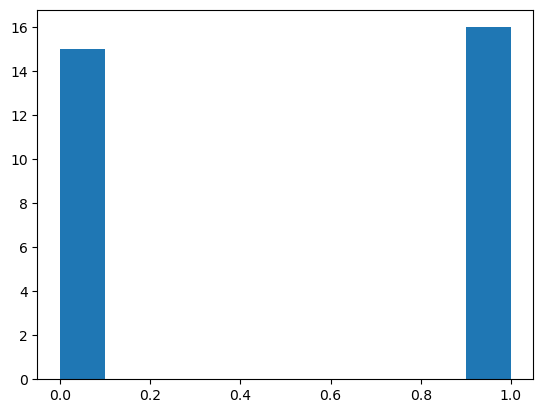

In [59]:
plt.hist([tup[1] for tup in DIN_state_array])

Text(0.5, 1.0, 'Din State Change against Timestamps')

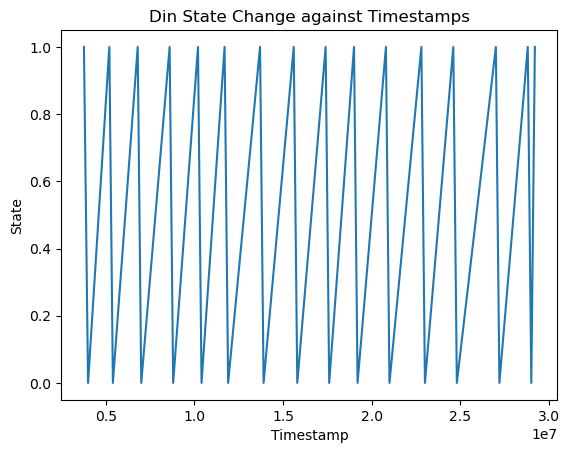

In [60]:
plt.plot([tup[0] for tup in DIN_state_array], [tup[1] for tup in DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

# Part 1.5: Inputting Data for Competition

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [290]:
input_folder = "./data"

In [291]:
# Accomodates for both capitalization of the file names
raw_data_file_keyword = '*[mM]edpc*'

- Asking the user what the path to the recording files are, with the option of using wildcards

- Make this cell into non-code block if you are using the same file path for multiple runs

In [298]:
raw_data_glob_pattern = "./data/20221122_164720_competition_subject_6_1_and_6_3.rec/subj_6_1"

- By default, this will search for files that are in the `./data` folder (in the folder that this notebook is in) that have key word you specified in the file name

In [299]:
# Using the user inputted path/pattern
if raw_data_glob_pattern.strip():
    # Getting a list of all matching files
    raw_data_files_list = glob.glob(raw_data_glob_pattern.strip())
    # Checking if there were any files that matched
    if raw_data_files_list:
        raw_data_file_path = raw_data_files_list[0]
    else:
        raise ValueError("No files were found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))

# Using the default pattern
else:
    # Searching for matching files with recursion
    if glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword)):
        raw_data_glob_pattern = os.path.join(input_folder + "**", raw_data_file_keyword)
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    # Searching for matching files only in the specified folder
    elif glob.glob(os.path.join(input_folder, raw_data_file_keyword)):
        raw_data_glob_pattern = glob.glob(os.path.join(input_folder, raw_data_file_keyword))
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    else:
        raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))


- Checking to see if only one file is specified

In [300]:
if len(raw_data_files_list) >= 2:
    raise ValueError("More than one file was found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))
else:
    # Using the first(and only file) as the file path
    raw_data_file_path = raw_data_files_list[0]

In [301]:
raw_data_file_path

'./data/20221122_164720_competition_subject_6_1_and_6_3.rec/subj_6_1'

## Extracting the data and the metadata from the Recording folder

- Creating a dictionary that has the directory as the key and a dictionary that has the file name as the key and the 

In [302]:
competition_file_to_data = trodes.read_exported.get_all_trodes_data_from_directory(raw_data_file_path)

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:70: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


file prefix: group0.coordinates.dat
directory prefix: kilosort
file prefix: timestamps.dat
directory prefix: kilosort
file prefix: spikeband_nt15ch1.dat
directory prefix: spikeband


/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_164720_competition_subject_6_1_and_6_3.rec/subj_6_1/20221122_164720_competition_6_1_top_3__base_3_merged.kilosort/20221122_164720_competition_6_1_top_3__base_3_merged.group0.dat
  warnings.warn("Can not process {}".format(absolute_file_path))


file prefix: spikeband_nt23ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt18ch1.dat
directory prefix: spikeband
file prefix: timestamps.dat
directory prefix: spikeband
file prefix: spikeband_nt32ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt5ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt17ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt8ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt4ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt11ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt2ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt10ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt31ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt19ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt30ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt26ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt20ch1.dat
directory prefix: spikeband
fil

file prefix: spikes_nt2.dat
directory prefix: spikes
file prefix: spikes_nt22.dat
directory prefix: spikes
file prefix: spikes_nt27.dat
directory prefix: spikes
file prefix: spikes_nt3.dat
directory prefix: spikes
file prefix: spikes_nt23.dat
directory prefix: spikes
file prefix: spikes_nt26.dat
directory prefix: spikes
file prefix: spikes_nt11.dat
directory prefix: spikes
file prefix: spikes_nt5.dat
directory prefix: spikes
file prefix: spikes_nt9.dat
directory prefix: spikes
file prefix: spikes_nt32.dat
directory prefix: spikes
file prefix: spikes_nt4.dat
directory prefix: spikes
file prefix: spikes_nt18.dat
directory prefix: spikes
file prefix: spikes_nt7.dat
directory prefix: spikes
file prefix: spikes_nt12.dat
directory prefix: spikes
file prefix: spikes_nt6.dat
directory prefix: spikes
file prefix: spikes_nt10.dat
directory prefix: spikes
file prefix: spikes_nt14.dat
directory prefix: spikes
file prefix: spikes_nt16.dat
directory prefix: spikes
file prefix: spikes_nt19.dat
direct

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_164720_competition_subject_6_1_and_6_3.rec/subj_6_1/20221122_164720_competition_6_1_top_3__base_3_merged.timestampoffset/20221122_164720_competition_6_1_top_3__base_3_merged.timestampoffset.txt
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20

file prefix: timestamps.dat
directory prefix: analog
file prefix: analog_Headstage_AccelX.dat
directory prefix: analog
file prefix: analog_ECU_Ain8.dat
directory prefix: analog
file prefix: analog_ECU_Aout3.dat
directory prefix: analog
file prefix: analog_Headstage_GyroX.dat
directory prefix: analog
file prefix: analog_Headstage_GyroZ.dat
directory prefix: analog
file prefix: analog_ECU_Aout1.dat
directory prefix: analog
file prefix: analog_ECU_Ain4.dat
directory prefix: analog
file prefix: analog_ECU_Ain3.dat
directory prefix: analog
file prefix: analog_ECU_Ain5.dat
directory prefix: analog
file prefix: analog_Headstage_MagZ.dat
directory prefix: analog
file prefix: analog_ECU_Ain1.dat
directory prefix: analog
file prefix: analog_ECU_Ain2.dat
directory prefix: analog
file prefix: analog_Controller_Ain1.dat
directory prefix: analog
file prefix: analog_ECU_Aout2.dat
directory prefix: analog
file prefix: analog_Headstage_AccelY.dat
directory prefix: analog
file prefix: analog_ECU_Ain7.da

- All the folders that were extracted from

In [303]:
competition_file_to_data.keys()

dict_keys(['20221122_164720_competition_6_1_top_3__base_3_merged.kilosort', 'kilosort', '20221122_164720_competition_6_1_top_3__base_3_merged.spikeband', 'spikeband', '20221122_164720_competition_6_1_top_3__base_3_merged.raw', 'raw', '20221122_164720_competition_6_1_top_3__base_3_merged.time', 'time', '20221122_164720_competition_6_1_top_3__base_3_merged.DIO', 'DIO', '20221122_164720_competition_6_1_top_3__base_3_merged.LFP', 'LFP', '20221122_164720_competition_6_1_top_3__base_3_merged.spikes', 'spikes', '20221122_164720_competition_6_1_top_3__base_3_merged.timestampoffset', '20221122_164720_competition_6_1_top_3__base_3_merged.mountainsort', 'mountainsort', '20221122_164720_competition_6_1_top_3__base_3_merged.analog', 'analog', '20221122_164720_competition_6_1_top_3__base_3_merged.stimulation', 'stimulation'])

In [304]:
competition_file_to_data["."]

{}

In [305]:
competition_file_to_data["20221122_164720_competition_6_1_top_3__base_3_merged.spikeband"]

{'spikeband_nt15ch1.dat': {'description': 'Spike band continuous data for one channel',
  'byte_order': 'little endian',
  'original_file': '20221122_164720_competition_6_1_top_3__base_3_merged.rec',
  'clockrate': '20000',
  'trodes_version': '2.3.2',
  'compile_date': 'Apr 12 2022',
  'compile_time': '15:21:02',
  'qt_version': '6.2.2',
  'commit_tag': 'heads/Release_2.3.2-0-g15f12712',
  'controller_firmware': '3.17',
  'headstage_firmware': '2.2',
  'controller_serialnum': '00104 00176',
  'headstage_serialnum': '01601 00133',
  'autosettle': '0',
  'smartref': '0',
  'gyro': '0',
  'accelerometer': '0',
  'magnetometer': '1',
  'time_offset': '0',
  'system_time_at_creation': '1669153654559',
  'timestamp_at_creation': '1032471',
  'first_timestamp': '1952691',
  'ntrode_id': '15',
  'num_channels': '1',
  'voltage_scaling': '0.195',
  'reference': 'off',
  'spike_invert': 'yes',
  'fields': '<voltage int16>',
  'data': array([(-300,), (-264,), (-254,), ..., (   0,), (   0,), (   

- Looking over all the extracted data

# Part 2: Looking over the data

## Looking over the ephys recording

- Getting the name of the ephys recording direcotry

In [306]:
raw_directory_dict = competition_file_to_data["raw"]

- Getting the name of the files in the ephys recording directory

In [307]:
raw_directory_dict.keys()

dict_keys(['group0.coordinates.dat', 'timestamps.dat', 'raw_group0.dat'])

In [308]:
raw_directory_dict

{'group0.coordinates.dat': {'description': 'Pad locations in microns',
  'byte_order': 'little endian',
  'original_file': '20221122_164720_competition_6_1_top_3__base_3_merged.rec',
  'clockrate': '20000',
  'trodes_version': '2.3.2',
  'compile_date': 'Apr 12 2022',
  'compile_time': '15:21:02',
  'qt_version': '6.2.2',
  'commit_tag': 'heads/Release_2.3.2-0-g15f12712',
  'controller_firmware': '3.17',
  'headstage_firmware': '2.2',
  'controller_serialnum': '00104 00176',
  'headstage_serialnum': '01601 00133',
  'autosettle': '0',
  'smartref': '0',
  'gyro': '0',
  'accelerometer': '0',
  'magnetometer': '1',
  'time_offset': '0',
  'system_time_at_creation': '1669153654559',
  'timestamp_at_creation': '1032471',
  'first_timestamp': '1952691',
  'fields': '<ml int32><dv int32><ap int32>',
  'data': array([(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0),
         (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0),
         (0, 0, 0), (0, 0, 0), (0, 0

In [309]:
raw_recording_fields_text = raw_directory_dict["raw_group0.dat"]

In [310]:
raw_recording_fields_text

{'description': 'Raw (unfiltered) data for one sorting group',
 'byte_order': 'little endian',
 'original_file': '20221122_164720_competition_6_1_top_3__base_3_merged.rec',
 'clockrate': '20000',
 'trodes_version': '2.3.2',
 'compile_date': 'Apr 12 2022',
 'compile_time': '15:21:02',
 'qt_version': '6.2.2',
 'commit_tag': 'heads/Release_2.3.2-0-g15f12712',
 'controller_firmware': '3.17',
 'headstage_firmware': '2.2',
 'controller_serialnum': '00104 00176',
 'headstage_serialnum': '01601 00133',
 'autosettle': '0',
 'smartref': '0',
 'gyro': '0',
 'accelerometer': '0',
 'magnetometer': '1',
 'time_offset': '0',
 'system_time_at_creation': '1669153654559',
 'timestamp_at_creation': '1032471',
 'first_timestamp': '1952691',
 'sorting_group': '0',
 'num_channels': '32',
 'voltage_scaling': '0.195',
 'fields': '<voltage 32*int16>',
 'data': array([([100, 362, 264, 200, 113, 287, 228, 271, 201, 585, 200, 222, 194, 296, 343, 556, 232, 222, 226, 205, 268, 265, 318, 248, 132, 128, 248, 198, 256

- Array of Voltages for each channel

In [311]:
voltage_value_array = raw_recording_fields_text["data"]

In [312]:
voltage_value_array.shape

(31984328,)

In [313]:
voltage_value_array[:5]

array([([100, 362, 264, 200, 113, 287, 228, 271, 201, 585, 200, 222, 194, 296, 343, 556, 232, 222, 226, 205, 268, 265, 318, 248, 132, 128, 248, 198, 256, 214, 262, 307],),
       ([166, 366, 171, 172, -12, 324, 296, 365, 275, 490, 285, 398, 274, 338, 309, 565, 278, 249, 256, 239, 327, 196, 351, 320, 163, 235, 195, 271, 200, 300, 242, 471],),
       ([257, 382, 387, 236, 132, 312, 471, 430, 338, 482, 293, 441, 325, 435, 346, 639, 398, 263, 130, 235, 449, 314, 409, 418, 254, 320, 351, 422, 187, 357, 256, 463],),
       ([331, 432, 305, 274, 185, 345, 379, 298, 345, 432, 267, 290, 412, 435, 326, 613, 320, 329, 258, 334, 447, 243, 388, 396, 322, 198, 324, 422, 350, 391, 314, 497],),
       ([313, 449, 307, 353, 271, 387, 473, 397, 415, 468, 477, 341, 256, 535, 410, 690, 427, 425, 264, 420, 552, 409, 450, 510, 448, 226, 312, 435, 278, 456, 329, 472],)],
      dtype=[('voltage', '<i2', (32,))])

- Voltage Time Stamps

In [314]:
raw_directory_dict.keys()

dict_keys(['group0.coordinates.dat', 'timestamps.dat', 'raw_group0.dat'])

In [315]:
voltage_timestamp_array = raw_directory_dict["timestamps.dat"]["data"]

In [316]:
voltage_timestamp_array[:5]

array([(1952691,), (1952692,), (1952693,), (1952694,), (1952695,)],
      dtype=[('time', '<u4')])

In [317]:
voltage_timestamp_array[-5:]

array([(33937014,), (33937015,), (33937016,), (33937017,), (33937018,)],
      dtype=[('time', '<u4')])

In [318]:
voltage_timestamp_array.shape

(31984328,)

- Converting the array to integers to be able to do calculations

    - u4 and i2 explanation: https://www.geeksforgeeks.org/data-type-object-dtype-numpy-python/

In [319]:
voltage_timestamp_array = voltage_timestamp_array.astype(int)

In [320]:
voltage_timestamp_array[:5]

array([1952691, 1952692, 1952693, 1952694, 1952695])

In [321]:
voltage_timestamp_array[-5:]

array([33937014, 33937015, 33937016, 33937017, 33937018])

In [322]:
voltage_timestamp_array.shape

(31984328,)

# Part 3: Converting everything into timestamps

## Voltage to timestamp

- Use the matching index to convert between the voltage time stamp and the recording

In [39]:
random_voltage_index = np.random.choice(voltage_timestamp_array.shape[0], 1, replace=False)  

In [40]:
random_voltage_index

array([2704649])

In [41]:
voltage_value_array[random_voltage_index]

array([([-593, -600, -395, -371, -439, -502, -401, -417, -529, -568, -485, -372, -473, -290, -798,  266, -537, -611, -564, -405, -465, -463, -513, -427, -483, -519, -470, -483, -541, -611, -450, -520],)],
      dtype=[('voltage', '<i2', (32,))])

- Getting the associated timestamp of the ephys recording

In [42]:
random_voltage_time_stamp = voltage_timestamp_array[random_voltage_index]

In [43]:
random_voltage_time_stamp

array([6476986])

# Part 4: Converting from timestamps back to everything

In [44]:
def timestamp_to_index(current_ts, ts_array):
    """
    """
    return np.argwhere(ts_array >= current_ts)[0][0]

## Time stamp to Voltage Value

In [45]:
random_voltage_time_stamp

array([6476986])

In [46]:
voltage_timestamp_array

array([ 3772337,  3772338,  3772339, ..., 26693550, 26693551, 26693552])

- Getting the index of the closest timestamp 

In [47]:
random_voltage_index = timestamp_to_index(current_ts=random_voltage_time_stamp, ts_array=voltage_timestamp_array)

In [48]:
random_voltage_index

2704649

- Checking if it matches to the original timestamp
    - Should be the same, because the sampling rate of the timestamps are based on the ephys recording

In [49]:
voltage_timestamp_array[random_voltage_index]

6476986

- Getting the voltage value based on the index

In [50]:
voltage_value_array[random_voltage_index]

([-593, -600, -395, -371, -439, -502, -401, -417, -529, -568, -485, -372, -473, -290, -798,  266, -537, -611, -564, -405, -465, -463, -513, -427, -483, -519, -470, -483, -541, -611, -450, -520],)

# Part 4: Syncing everything based on timestamps

# Syncing with MED-PC

In [51]:
DIO_directory_name = trodes.read_exported.get_key_with_substring(file_to_data, substring="DIO")

In [52]:
DIO_directory_name

'DIO'

In [53]:
DIO_directory_dict = file_to_data[DIO_directory_name]

In [54]:
DIO_directory_dict.keys()

dict_keys(['dio_ECU_Dout24.dat', 'dio_ECU_Dout26.dat', 'dio_ECU_Din4.dat', 'dio_ECU_Dout6.dat', 'dio_ECU_Din3.dat', 'dio_ECU_Din2.dat', 'dio_ECU_Dout16.dat', 'dio_ECU_Dout3.dat', 'dio_ECU_Din14.dat', 'dio_ECU_Dout31.dat', 'dio_ECU_Din23.dat', 'dio_ECU_Din12.dat', 'dio_ECU_Dout17.dat', 'dio_ECU_Dout15.dat', 'dio_ECU_Din6.dat', 'dio_ECU_Dout1.dat', 'dio_Controller_Din7.dat', 'dio_ECU_Din8.dat', 'dio_ECU_Dout5.dat', 'dio_ECU_Dout8.dat', 'dio_ECU_Din27.dat', 'dio_Controller_Din3.dat', 'dio_ECU_Dout19.dat', 'dio_ECU_Dout20.dat', 'dio_ECU_Dout29.dat', 'dio_ECU_Dout22.dat', 'dio_ECU_Din22.dat', 'dio_ECU_Din24.dat', 'dio_ECU_Din20.dat', 'dio_ECU_Din30.dat', 'dio_ECU_Din10.dat', 'dio_ECU_Dout12.dat', 'dio_Controller_Din5.dat', 'dio_ECU_Din19.dat', 'dio_ECU_Din25.dat', 'dio_ECU_Dout28.dat', 'dio_Controller_Din4.dat', 'dio_ECU_Dout21.dat', 'dio_ECU_Dout30.dat', 'dio_ECU_Din26.dat', 'dio_ECU_Din5.dat', 'dio_ECU_Dout32.dat', 'dio_Controller_Din6.dat', 'dio_Controller_Din8.dat', 'dio_ECU_Din7.dat', 

In [55]:
DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="ECU_Din1.dat", return_first=True)

In [56]:
DIN_file_name

'dio_ECU_Din1.dat'

In [57]:
DIN_state_array = DIO_directory_dict[DIN_file_name]["data"]

In [58]:
DIN_state_array

array([( 3772337, 1), ( 4003716, 0), ( 5204112, 1), ( 5404109, 0),
       ( 6804107, 1), ( 7004109, 0), ( 8604101, 1), ( 8804103, 0),
       (10204096, 1), (10404098, 0), (11704091, 1), (11904090, 0),
       (13704085, 1), (13904082, 0), (15604082, 1), (15804078, 0),
       (17404074, 1), (17604073, 0), (19004066, 1), (19204065, 0),
       (20804062, 1), (21004062, 0), (22804059, 1), (23004055, 0),
       (24604051, 1), (24804050, 0), (27004044, 1), (27204043, 0),
       (28804038, 1), (29004037, 0), (29203637, 1)],
      dtype=[('time', '<u4'), ('state', 'u1')])

(array([15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

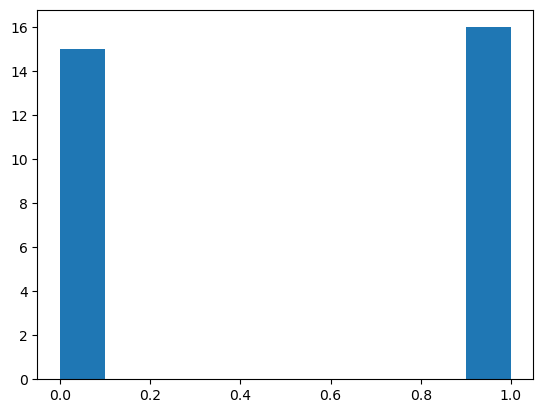

In [59]:
plt.hist([tup[1] for tup in DIN_state_array])

Text(0.5, 1.0, 'Din State Change against Timestamps')

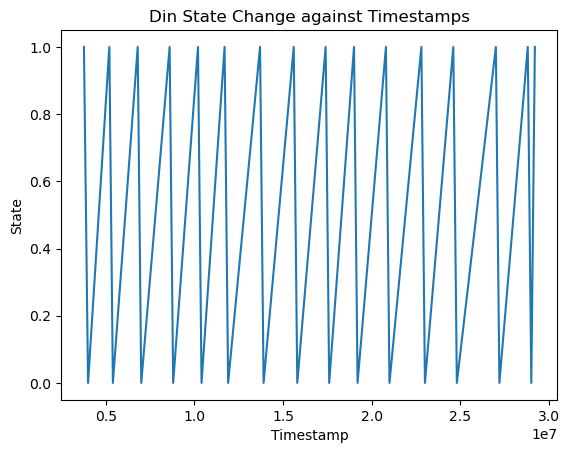

In [60]:
plt.plot([tup[0] for tup in DIN_state_array], [tup[1] for tup in DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

# Reading in Phy

- The times that all the spikes happened

In [61]:
spike_times = np.load("./subject_6_1/proc/phy/spike_times.npy")

In [62]:
spike_times[:10]

array([[ 32],
       [106],
       [156],
       [201],
       [246],
       [281],
       [349],
       [386],
       [479],
       [559]])

- Which unit the spike came from

In [63]:
spike_clusters = np.load("./subject_6_1/proc/phy/spike_clusters.npy")

In [64]:
spike_clusters[:10]

array([64,  6, 59, 23, 23, 27, 27,  9, 55, 56], dtype=int32)

- The classification of each unit

In [65]:
cluster_group_df = pd.read_csv("./subject_6_1/proc/phy/cluster_group.tsv", sep="\t")

In [66]:
cluster_group_df

,cluster_id,group
0,1,noise
1,2,noise
2,4,good
3,5,noise
4,6,good
...,...,...
70,90,noise
71,93,mua
72,94,noise
73,101,good


- Filtering for the good units

In [67]:
good_unit_unique_ids = cluster_group_df[cluster_group_df["group"] == "good"]["cluster_id"].values

In [68]:
good_unit_unique_ids

array([  4,   6,  10,  12,  15,  48,  53,  55,  64,  71,  73,  79,  83,
       101])

- Getting a list of the IDs that were good from the list of unit ids for all the firings

In [69]:
good_unit_mask = np.isin(spike_clusters, good_unit_unique_ids)

In [70]:
good_unit_all_ids = spike_clusters[good_unit_mask]

In [71]:
good_unit_all_ids.shape

(144276,)

In [72]:
good_unit_all_ids[:10]

array([64,  6, 55, 15,  6, 55, 10, 15,  6, 55], dtype=int32)

- Getting the time that the good units fired

In [73]:
good_unit_times = spike_times[good_unit_mask].T[0]

In [74]:
good_unit_times.shape

(144276,)

In [75]:
good_unit_times[:10]

array([  32,  106,  479, 1120, 1383, 1493, 1668, 1740, 2353, 2600])

In [76]:
good_unit_times[-10:]

array([56842855, 56843167, 56844643, 56844863, 56846404, 56865558,
       56891994, 56935888, 56949135, 56997479])

## Syncing the unit times with the ECU times

- List of when the ECU has changed signal. 1 means that the ECU Din1 signal is on, 0 means it's off.

In [77]:
DIN_state_array

array([( 3772337, 1), ( 4003716, 0), ( 5204112, 1), ( 5404109, 0),
       ( 6804107, 1), ( 7004109, 0), ( 8604101, 1), ( 8804103, 0),
       (10204096, 1), (10404098, 0), (11704091, 1), (11904090, 0),
       (13704085, 1), (13904082, 0), (15604082, 1), (15804078, 0),
       (17404074, 1), (17604073, 0), (19004066, 1), (19204065, 0),
       (20804062, 1), (21004062, 0), (22804059, 1), (23004055, 0),
       (24604051, 1), (24804050, 0), (27004044, 1), (27204043, 0),
       (28804038, 1), (29004037, 0), (29203637, 1)],
      dtype=[('time', '<u4'), ('state', 'u1')])

- Getting only the times when the ECU signal was on

In [78]:
tone_din_time = [din_time for din_time, din_state in DIN_state_array if din_state == 1]

In [79]:
tone_din_time

[3772337,
 5204112,
 6804107,
 8604101,
 10204096,
 11704091,
 13704085,
 15604082,
 17404074,
 19004066,
 20804062,
 22804059,
 24604051,
 27004044,
 28804038,
 29203637]

- Because spike sorting is 0-indexed, we must make all the tone time also 0-indexed. We will do this by subtracting the first index from the ephys recording for all the tone times.

In [80]:
voltage_timestamp_array

array([ 3772337,  3772338,  3772339, ..., 26693550, 26693551, 26693552])

In [81]:
all_tone_unit_time = [tone_unit_time - voltage_timestamp_array[0] for tone_unit_time in tone_din_time]

In [82]:
all_tone_unit_time

[0,
 1431775,
 3031770,
 4831764,
 6431759,
 7931754,
 9931748,
 11831745,
 13631737,
 15231729,
 17031725,
 19031722,
 20831714,
 23231707,
 25031701,
 25431300]

- Checking to see what the time looks like for each tone. The first one is 0, so can be ignored. The last one can also be ignored because it's different by a smaller time than the time between tones compared to the previous one 

In [83]:
[x / 20000 for x in all_tone_unit_time]

[0.0,
 71.58875,
 151.5885,
 241.5882,
 321.58795,
 396.5877,
 496.5874,
 591.58725,
 681.58685,
 761.58645,
 851.58625,
 951.5861,
 1041.5857,
 1161.58535,
 1251.58505,
 1271.565]

- So we must remove first and last instance because they are just the start and stop of the program and not the actual tone

In [84]:
all_tone_unit_time = all_tone_unit_time[1:-1]

In [85]:
all_tone_unit_time

[1431775,
 3031770,
 4831764,
 6431759,
 7931754,
 9931748,
 11831745,
 13631737,
 15231729,
 17031725,
 19031722,
 20831714,
 23231707,
 25031701]

In [86]:
len(all_tone_unit_time)

14

## Seeing which tone time each unit time is closest to

- We will divide all the time up into bins of before and after each tone. Then we will see which time bin the neuron firing falls into.
    - So everything in the 0 bin would be before the first time bin. The 1 bin would be everything in between the first and second time bin. The last would be everything after last time bin.

In [87]:
good_unit_bins = np.digitize(good_unit_times, all_tone_unit_time, right=True)

In [88]:
good_unit_bins.shape

(144276,)

In [89]:
good_unit_bins[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [90]:
good_unit_bins[-10:]

array([14, 14, 14, 14, 14, 14, 14, 14, 14, 14])

- Seeing if the firing time is within a 5 second interval of any tone

In [91]:
from collections import defaultdict

In [92]:
within_interval_unit_times = defaultdict(list)
for index, time in enumerate(good_unit_times):
    try:
        current_bin = good_unit_bins[index]


        # checking number before
        first_tone_time = all_tone_unit_time[current_bin - 1]
        if time >= first_tone_time - 5 * 20000 and time <= first_tone_time + 10 * 20000:
            within_interval_unit_times[first_tone_time].append((first_tone_time, index, time, good_unit_all_ids[index]))

        # checking number after
        second_tone_time = all_tone_unit_time[current_bin]
        if time >= second_tone_time - 5 * 20000 and time <= second_tone_time + 10 * 20000:
            within_interval_unit_times[second_tone_time].append((second_tone_time, index, time, good_unit_all_ids[index]))
    except:
        pass

In [93]:
within_interval_unit_times[all_tone_unit_time[0]][:10]

[(1431775, 4051, 1331964, 64),
 (1431775, 4052, 1332422, 53),
 (1431775, 4053, 1332513, 15),
 (1431775, 4054, 1332786, 64),
 (1431775, 4055, 1333224, 64),
 (1431775, 4056, 1333491, 6),
 (1431775, 4057, 1333971, 64),
 (1431775, 4058, 1334117, 64),
 (1431775, 4059, 1334431, 15),
 (1431775, 4060, 1335551, 64)]

In [94]:
within_interval_unit_times[all_tone_unit_time[-1]][:10]

[(25031701, 74660, 24931775, 79),
 (25031701, 74661, 24932107, 79),
 (25031701, 74662, 24932439, 79),
 (25031701, 74663, 24932484, 79),
 (25031701, 74664, 24932776, 79),
 (25031701, 74665, 24932996, 71),
 (25031701, 74666, 24933107, 79),
 (25031701, 74667, 24933328, 71),
 (25031701, 74668, 24933440, 79),
 (25031701, 74669, 24933662, 71)]

## Seeing which 100ms bin each unit time belongs to

- Creating bins for each 100ms time interval

In [95]:
tone_unit_time_to_interval = {}
for time in all_tone_unit_time:
    tone_unit_time_to_interval[time] = [time + num * 2000 for num in range(-50, 100)]

In [96]:
len(tone_unit_time_to_interval[all_tone_unit_time[0]])

150

- Seeing which bin the tone time fits into

In [97]:
all_bin_mapping = None
for key, value in within_interval_unit_times.items():
    unit_fire_time = [fire_time for tone_time, index, fire_time, unit_id in value]
    unit_fire_bin = np.digitize(unit_fire_time, tone_unit_time_to_interval[key], right=True)
    current_tone_bin_map = np.hstack((np.array(value), unit_fire_bin[np.newaxis].T))
    if all_bin_mapping is None:
        all_bin_mapping = current_tone_bin_map
    else: 
        all_bin_mapping = np.vstack((all_bin_mapping, current_tone_bin_map))
    

In [98]:
all_bin_mapping

array([[ 1431775,     4051,  1331964,       64,        1],
       [ 1431775,     4052,  1332422,       53,        1],
       [ 1431775,     4053,  1332513,       15,        1],
       ...,
       [25031701,    75938, 25230923,       83,      150],
       [25031701,    75939, 25231154,       79,      150],
       [25031701,    75940, 25231390,       64,      150]])

## Calculating Firing Rate

In [99]:
from collections import Counter, defaultdict

- Creating a reference for all the tone bin combinations to each tone
    - This is because we need a unique identifier for each tone and bin combination. So we will just add the numbers

In [100]:
tone_bin_for_index = all_bin_mapping[:,0] + all_bin_mapping[:,4]

In [101]:
tone_bin_to_tone = np.hstack((tone_bin_for_index[np.newaxis].T, all_bin_mapping[:,0][np.newaxis].T))

In [102]:
tone_bin_to_tone

array([[ 1431776,  1431775],
       [ 1431776,  1431775],
       [ 1431776,  1431775],
       ...,
       [25031851, 25031701],
       [25031851, 25031701],
       [25031851, 25031701]])

In [103]:
tone_bin_to_tone = dict(zip(tone_bin_to_tone[:,0], tone_bin_to_tone[:,1]))

In [104]:
tone_bin_to_tone

{1431776: 1431775,
 1431777: 1431775,
 1431778: 1431775,
 1431779: 1431775,
 1431780: 1431775,
 1431781: 1431775,
 1431782: 1431775,
 1431783: 1431775,
 1431784: 1431775,
 1431785: 1431775,
 1431786: 1431775,
 1431787: 1431775,
 1431788: 1431775,
 1431789: 1431775,
 1431790: 1431775,
 1431791: 1431775,
 1431792: 1431775,
 1431793: 1431775,
 1431794: 1431775,
 1431795: 1431775,
 1431796: 1431775,
 1431797: 1431775,
 1431798: 1431775,
 1431799: 1431775,
 1431800: 1431775,
 1431801: 1431775,
 1431802: 1431775,
 1431803: 1431775,
 1431804: 1431775,
 1431805: 1431775,
 1431806: 1431775,
 1431807: 1431775,
 1431808: 1431775,
 1431809: 1431775,
 1431810: 1431775,
 1431811: 1431775,
 1431812: 1431775,
 1431813: 1431775,
 1431814: 1431775,
 1431815: 1431775,
 1431816: 1431775,
 1431817: 1431775,
 1431818: 1431775,
 1431819: 1431775,
 1431820: 1431775,
 1431821: 1431775,
 1431822: 1431775,
 1431823: 1431775,
 1431824: 1431775,
 1431825: 1431775,
 1431826: 1431775,
 1431827: 1431775,
 1431828: 14

In [105]:
tone_bin_for_index

array([ 1431776,  1431776,  1431776, ..., 25031851, 25031851, 25031851])

- Getting the number of times each neuron fires

In [106]:
firing_counts = defaultdict(lambda: defaultdict(dict))
for tone_time, index, firing_time, unit_id, bin_index in all_bin_mapping:
    tone_bin = tone_time + bin_index
    if firing_counts[unit_id][tone_bin]:
        firing_counts[unit_id][tone_bin] += 1
    else:
        firing_counts[unit_id][tone_bin] = 1

In [107]:
firing_rate_df = pd.DataFrame.from_dict(firing_counts)

In [108]:
firing_rate_df = firing_rate_df.fillna(value=0)

In [109]:
firing_rate_df.head()

,64,53,15,6,71,79,48,73,55,101,12,83,10,4
1431776,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1431777,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1431778,4.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1431779,2.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1431780,2.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
firing_rate_df.loc[:].values

array([[3., 1., 1., ..., 0., 0., 0.],
       [3., 0., 1., ..., 0., 0., 0.],
       [4., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

- Classifying each time stamp

In [111]:
all_bin_mapping

array([[ 1431775,     4051,  1331964,       64,        1],
       [ 1431775,     4052,  1332422,       53,        1],
       [ 1431775,     4053,  1332513,       15,        1],
       ...,
       [25031701,    75938, 25230923,       83,      150],
       [25031701,    75939, 25231154,       79,      150],
       [25031701,    75940, 25231390,       64,      150]])

In [112]:
all_bin_mapping[:, 0]

array([ 1431775,  1431775,  1431775, ..., 25031701, 25031701, 25031701])

In [113]:
all_bin_mapping[:, 2]

array([ 1331964,  1332422,  1332513, ..., 25230923, 25231154, 25231390])

- Making a dictionary that maps all the firing times to the corresponding tone

In [114]:
fire_to_tone_time = dict(zip(all_bin_mapping[:, 2], all_bin_mapping[:, 0]))

In [115]:
fire_to_tone_time

{1331964: 1431775,
 1332422: 1431775,
 1332513: 1431775,
 1332786: 1431775,
 1333224: 1431775,
 1333491: 1431775,
 1333971: 1431775,
 1334117: 1431775,
 1334431: 1431775,
 1335551: 1431775,
 1335630: 1431775,
 1336054: 1431775,
 1336256: 1431775,
 1336582: 1431775,
 1337019: 1431775,
 1337133: 1431775,
 1337390: 1431775,
 1337727: 1431775,
 1338125: 1431775,
 1338622: 1431775,
 1338666: 1431775,
 1338738: 1431775,
 1339225: 1431775,
 1339427: 1431775,
 1340144: 1431775,
 1340310: 1431775,
 1340472: 1431775,
 1340982: 1431775,
 1341724: 1431775,
 1342021: 1431775,
 1342141: 1431775,
 1342375: 1431775,
 1343458: 1431775,
 1343750: 1431775,
 1344143: 1431775,
 1344354: 1431775,
 1344475: 1431775,
 1344800: 1431775,
 1345023: 1431775,
 1345472: 1431775,
 1345639: 1431775,
 1346320: 1431775,
 1346626: 1431775,
 1346688: 1431775,
 1346838: 1431775,
 1347139: 1431775,
 1347655: 1431775,
 1348073: 1431775,
 1348846: 1431775,
 1349238: 1431775,
 1349978: 1431775,
 1350023: 1431775,
 1350137: 14

In [116]:
fire_to_tone_time[1331964]

1431775

In [117]:
firing_rate_df = firing_rate_df.reset_index()

- Labeling which tone time that fire time belongs to

In [118]:
firing_rate_df["tone_time"] = firing_rate_df["index"].map(tone_bin_to_tone)

In [119]:
firing_rate_df.head()

,index,64,53,15,6,71,79,48,73,55,101,12,83,10,4,tone_time
0,1431776,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1431775
1,1431777,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1431775
2,1431778,4.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1431775
3,1431779,2.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1431775
4,1431780,2.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1431775


In [120]:
firing_rate_df["bin"] = firing_rate_df["index"] - firing_rate_df["tone_time"]

In [121]:
rewarded_trials = [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1]

In [122]:
all_tone_unit_time

[1431775,
 3031770,
 4831764,
 6431759,
 7931754,
 9931748,
 11831745,
 13631737,
 15231729,
 17031725,
 19031722,
 20831714,
 23231707,
 25031701]

In [123]:
tone_to_reward = {}
for tone_time, reward_bool in zip(all_tone_unit_time, rewarded_trials):
    tone_to_reward[tone_time] = reward_bool

In [124]:
tone_to_reward

{1431775: 1,
 3031770: 1,
 4831764: 1,
 6431759: 0,
 7931754: 1,
 9931748: 1,
 11831745: 1,
 13631737: 1,
 15231729: 0,
 17031725: 1,
 19031722: 1,
 20831714: 0,
 23231707: 1,
 25031701: 1}

In [125]:
firing_rate_df["rewarded_bool"] = firing_rate_df["tone_time"].map(tone_to_reward)

In [126]:
firing_rate_df["rewarded_category"] = firing_rate_df["rewarded_bool"].map({0:"Omission", 1: "Rewarded"})

In [127]:
firing_rate_df

,index,64,53,15,6,71,79,48,73,55,101,12,83,10,4,tone_time,bin,rewarded_bool,rewarded_category
0,1431776,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1431775,1,1,Rewarded
1,1431777,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1431775,2,1,Rewarded
2,1431778,4.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1431775,3,1,Rewarded
3,1431779,2.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1431775,4,1,Rewarded
4,1431780,2.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1431775,5,1,Rewarded
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092,19031791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,19031722,69,1,Rewarded
2093,23231736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,23231707,29,1,Rewarded
2094,13631785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13631737,48,1,Rewarded
2095,6431775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6431759,16,0,Omission


In [128]:
averaged_firing_rate_df = firing_rate_df.groupby(['bin', 'rewarded_category']).mean()

In [129]:
averaged_firing_rate_df

index        64        53        15         6  \
bin rewarded_category                                                         
1   Omission           1.416507e+07  1.000000  0.000000  0.333333  0.666667   
    Rewarded           1.244992e+07  1.272727  0.181818  0.181818  0.272727   
2   Omission           1.416507e+07  1.000000  0.000000  0.000000  0.000000   
    Rewarded           1.244992e+07  1.545455  0.090909  0.272727  0.272727   
3   Omission           1.416507e+07  1.000000  0.000000  0.000000  0.333333   
...                             ...       ...       ...       ...       ...   
148 Rewarded           1.245007e+07  1.363636  0.000000  0.363636  1.090909   
149 Omission           1.416522e+07  2.000000  0.000000  0.000000  0.666667   
    Rewarded           1.245007e+07  1.090909  0.000000  0.545455  0.818182   
150 Omission           1.416522e+07  2.333333  0.000000  0.333333  0.333333   
    Rewarded           1.245007e+07  1.545455  0.000000  0.454545  1.000000   

                             71        79        48        73        55  \
bin rewarded_category                                                     
1   Omission           1.000000  2.333333  0.000000  0.333333  0.666667   
    Rewarded           2.000000  3.000000  0.000000  0.000000  0.090909   
2   Omission           1.666667  3.333333  0.000000  0.333333  0.666667   
    Rewarded           2.090909  3.000000  0.000000  0.000000  0.272727   
3   Omission           1.666667  3.000000  0.333333  0.000000  0.333333   
...                         ...       ...       ...       ...       ...   
148 Rewarded           1.090909  2.272727  0.090909  0.000000  0.363636   
149 Omission           1.666667  2.666667  0.000000  0.000000  0.333333   
    Rewarded           1.090909  2.727273  0.181818  0.090909  0.545455   
150 Omission           1.333333  2.666667  0.000000  0.000000  1.000000   
    Rewarded           1.636364  2.545455  0.090909  0.000000  0.727273   

                            101        12        83   10         4  \
bin rewarded_category                                                
1   Omission           0.000000  0.000000  0.000000  0.0  0.000000   
    Rewarded           0.000000  0.000000  0.000000  0.0  0.090909   
2   Omission           0.000000  0.000000  0.000000  0.0  0.000000   
    Rewarded           0.000000  0.000000  0.090909  0.0  0.000000   
3   Omission           0.000000  0.000000  0.000000  0.0  0.000000   
...                         ...       ...       ...  ...       ...   
148 Rewarded           0.272727  0.000000  0.090909  0.0  0.000000   
149 Omission           0.000000  0.000000  0.000000  0.0  0.000000   
    Rewarded           0.000000  0.000000  0.090909  0.0  0.000000   
150 Omission           0.000000  0.000000  0.000000  0.0  0.000000   
    Rewarded           0.000000  0.090909  0.181818  0.0  0.000000   

                          tone_time  rewarded_bool  
bin rewarded_category                               
1   Omission           1.416507e+07            0.0  
    Rewarded           1.244992e+07            1.0  
2   Omission           1.416507e+07            0.0  
    Rewarded           1.244992e+07            1.0  
3   Omission           1.416507e+07            0.0  
...                             ...            ...  
148 Rewarded           1.244992e+07            1.0  
149 Omission           1.416507e+07            0.0  
    Rewarded           1.244992e+07            1.0  
150 Omission           1.416507e+07            0.0  
    Rewarded           1.244992e+07            1.0  

[300 rows x 17 columns]

In [158]:
numerical_columns = [col for col in averaged_firing_rate_df.columns if type(col) == int]

In [162]:
transposed_averaged_firing_rate_df = averaged_firing_rate_df[numerical_columns].transpose()

In [163]:
transposed_averaged_firing_rate_df

bin                     1                   2                   3              \
rewarded_category  Omission  Rewarded  Omission  Rewarded  Omission  Rewarded   
64                 1.000000  1.272727  1.000000  1.545455  1.000000  1.636364   
53                 0.000000  0.181818  0.000000  0.090909  0.000000  0.090909   
15                 0.333333  0.181818  0.000000  0.272727  0.000000  0.000000   
6                  0.666667  0.272727  0.000000  0.272727  0.333333  0.636364   
71                 1.000000  2.000000  1.666667  2.090909  1.666667  2.000000   
79                 2.333333  3.000000  3.333333  3.000000  3.000000  3.090909   
48                 0.000000  0.000000  0.000000  0.000000  0.333333  0.000000   
73                 0.333333  0.000000  0.333333  0.000000  0.000000  0.000000   
55                 0.666667  0.090909  0.666667  0.272727  0.333333  0.363636   
101                0.000000  0.000000  0.000000  0.000000  0.000000  0.090909   
12                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
83                 0.000000  0.000000  0.000000  0.090909  0.000000  0.000000   
10                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4                  0.000000  0.090909  0.000000  0.000000  0.000000  0.000000   

bin                     4                   5              ...       146  \
rewarded_category  Omission  Rewarded  Omission  Rewarded  ...  Omission   
64                 0.666667  1.909091  0.333333  1.545455  ...  1.000000   
53                 0.000000  0.090909  0.000000  0.000000  ...  0.000000   
15                 0.333333  0.636364  0.000000  0.181818  ...  0.333333   
6                  0.000000  0.363636  0.333333  0.545455  ...  0.333333   
71                 1.666667  1.363636  4.000000  1.454545  ...  1.000000   
79                 3.333333  2.090909  4.666667  1.909091  ...  2.000000   
48                 0.000000  0.272727  0.333333  0.000000  ...  0.333333   
73                 0.000000  0.090909  0.000000  0.000000  ...  0.000000   
55                 0.333333  0.636364  0.333333  0.272727  ...  0.333333   
101                0.000000  0.000000  0.000000  0.000000  ...  0.000000   
12                 0.000000  0.000000  0.000000  0.000000  ...  0.000000   
83                 0.000000  0.000000  0.000000  0.000000  ...  0.000000   
10                 0.000000  0.000000  0.000000  0.000000  ...  0.000000   
4                  0.000000  0.000000  0.000000  0.000000  ...  0.333333   

bin                               147                 148                 149  \
rewarded_category  Rewarded  Omission  Rewarded  Omission  Rewarded  Omission   
64                 1.727273  2.000000  2.181818  2.000000  1.363636  2.000000   
53                 0.000000  0.333333  0.000000  0.000000  0.000000  0.000000   
15                 0.636364  0.333333  0.454545  0.000000  0.363636  0.000000   
6                  0.818182  0.666667  0.818182  0.666667  1.090909  0.666667   
71                 1.454545  3.000000  1.454545  2.666667  1.090909  1.666667   
79                 2.454545  0.666667  3.000000  3.666667  2.272727  2.666667   
48                 0.000000  0.000000  0.090909  0.000000  0.090909  0.000000   
73                 0.090909  0.000000  0.000000  0.000000  0.000000  0.000000   
55                 0.636364  0.333333  0.636364  0.666667  0.363636  0.333333   
101                0.181818  0.000000  0.090909  0.000000  0.272727  0.000000   
12                 0.000000  0.000000  0.090909  0.000000  0.000000  0.000000   
83                 0.000000  0.333333  0.000000  0.000000  0.090909  0.000000   
10                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4                  0.000000  0.333333  0.000000  0.000000  0.000000  0.000000   

bin                               150            
rewarded_category  Rewarded  Omission  Rewarded  
64                 1.090909  2.333333  1.545455  
53                 0.000000  0.000000  

In [164]:
resetted_averaged_firing_rate_array = transposed_averaged_firing_rate_df.values

In [165]:
resetted_averaged_firing_rate_array

array([[1.        , 1.27272727, 1.        , ..., 1.09090909, 2.33333333,
        1.54545455],
       [0.        , 0.18181818, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 0.18181818, 0.        , ..., 0.54545455, 0.33333333,
        0.45454545],
       ...,
       [0.        , 0.        , 0.        , ..., 0.09090909, 0.        ,
        0.18181818],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.09090909, 0.        , ..., 0.        , 0.        ,
        0.        ]])

# PCA with Neuron Rows

## Standarizing the Data

- TODO: Check why the 0s are being scaled differently

In [166]:
from sklearn.preprocessing import StandardScaler

In [167]:
# Separating out the features
x = resetted_averaged_firing_rate_array#.loc[:].values# Separating out the target
resetted_averaged_firing_rate_array = StandardScaler().fit_transform(x)

## Calculating the PCA

In [168]:
from sklearn.decomposition import PCA


In [169]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(resetted_averaged_firing_rate_array)
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [171]:
principal_df.head()

,principal component 1,principal component 2
0,23.046689,10.966681
1,-11.066172,-1.512890
2,4.182009,7.670974
3,-0.140833,1.070498
4,22.082930,-1.905248


In [192]:
principal_df["principal component 1"]

0     23.046689
1    -11.066172
2      4.182009
3     -0.140833
4     22.082930
5     37.706254
6     -9.831633
7    -10.706443
8      0.741351
9    -10.499764
10   -11.117916
11   -10.998723
12   -11.768092
13   -11.629658
Name: principal component 1, dtype: float64

In [202]:
pc1_product = transposed_averaged_firing_rate_df.reset_index().multiply(principal_df["principal component 1"], axis="index")

In [204]:
pc1_product

bin                      index          1                       2              \
rewarded_category                Omission    Rewarded    Omission    Rewarded   
0                  1474.988112  23.046689   29.332150   23.046689   35.617611   
1                  -586.507109  -0.000000   -2.012031   -0.000000   -1.006016   
2                    62.730134   1.394003    0.760365    0.000000    1.140548   
3                    -0.844998  -0.093889   -0.038409   -0.000000   -0.038409   
4                  1567.888039  22.082930   44.165860   36.804884   46.173399   
5                  2978.794080  87.981260  113.118763  125.687514  113.118763   
6                  -471.918361  -0.000000   -0.000000   -0.000000   -0.000000   
7                  -781.570343  -3.568814   -0.000000   -3.568814   -0.000000   
8                    40.774326   0.494234    0.067396    0.494234    0.202187   
9                 -1060.476142  -0.000000   -0.000000   -0.000000   -0.000000   
10                 -133.414990  -0.000000   -0.000000   -0.000000   -0.000000   
11                 -912.894039  -0.000000   -0.000000   -0.000000   -0.999884   
12                 -117.680919  -0.000000   -0.000000   -0.000000   -0.000000   
13                  -46.518634  -0.000000   -1.057242   -0.000000   -0.000000   

bin                         3                       4                      5  \
rewarded_category    Omission    Rewarded    Omission   Rewarded    Omission   
0                   23.046689   37.712764   15.364460  43.998225    7.682230   
1                   -0.000000   -1.006016   -0.000000  -1.006016   -0.000000   
2                    0.000000    0.000000    1.394003   2.661278    0.000000   
3                   -0.046944   -0.089621   -0.000000  -0.051212   -0.046944   
4                   36.804884   44.165860   36.804884  30.113087   88.331720   
5                  113.118763  116.546604  125.687514  78.840350  175.962520   
6                   -3.277211   -0.000000   -0.000000  -2.681354   -3.277211   
7                   -0.000000   -0.000000   -0.000000  -0.973313   -0.000000   
8                    0.247117    0.269582    0.247117   0.471769    0.247117   
9                   -0.000000   -0.954524   -0.000000  -0.000000   -0.000000   
10                  -0.000000   -0.000000   -0.000000  -0.000000   -0.000000   
11                  -0.000000   -0.000000   -0.000000  -0.000000   -0.000000   
12                  -0.000000   -0.000000   -0.000000  -0.000000   -0.000000   
13                  -0.000000   -0.000000   -0.000000  -0.000000   -0.000000   

bin                ...        146                   147              \
rewarded_category  ...   Omission   Rewarded   Omission    Rewarded   
0                  ...  23.046689  39.807918  46.093379   50.283686   
1                  ...  -0.000000  -0.000000  -3.688724   -0.000000   
2                  ...   1.394003   2.661278   1.394003    1.900913   
3                  ...  -0.046944  -0.115227  -0.093889   -0.115227   
4                  ...  22.082930  32.120626  66.248790   32.120626   
5                  ...  75.412508  92.551715  25.137503  113.118763   
6                  ...  -3.277211  -0.000000  -0.000000   -0.893785   
7                  ...  -0.000000  -0.973313  -0.000000   -0.000000   
8                  ...   0.247117   0.471769   0.247117    0.471769   
9                  ...  -0.000000  -1.909048  -0.000000   -0.954524   
10                 ...  -0.000000  -0.000000  -0.000000   -1.010720   
11                 ...  -0.000000  -0.000000  -3.666241   -0.000000   
12                 ...  -0.000000  -0.000000  -0.000000   -0.000000   
13                 ...  -3.876553  -0.000000  -3.876553   -0.000000   

bin                       148                    149                     150  \
rewarded_category    Omission   Rewarded    Omission    Rewarded    Omission   
0                   46.093379  31.427304   46.093379   25.141843   53.775608   
1                   -0.000000  -0.000000   -0

In [206]:
pc1_product.mean()

bin    rewarded_category
index                       143.810654
1      Omission               9.381172
       Rewarded              13.166918
2      Omission              13.033179
       Rewarded              13.872014
                               ...    
148    Rewarded               9.863803
149    Omission              13.114393
       Rewarded              10.776930
150    Omission              13.275567
       Rewarded              11.866275
Length: 301, dtype: float64

In [203]:
pc2_product = transposed_averaged_firing_rate_df.reset_index().multiply(principal_df["principal component 2"], axis="index")

In [205]:
pc2_product

bin                     index          1                     2             \
rewarded_category               Omission   Rewarded   Omission   Rewarded   
0                  701.867587  10.966681  13.957594  10.966681  16.948507   
1                  -80.183160  -0.000000  -0.275071  -0.000000  -0.137535   
2                  115.064614   2.556991   1.394723   0.000000   2.092084   
3                    6.422988   0.713665   0.291954   0.000000   0.291954   
4                 -135.272643  -1.905248  -3.810497  -3.175414  -3.983701   
5                 -753.116368 -22.243943 -28.599356 -31.777062 -28.599356   
6                  -48.426338  -0.000000  -0.000000  -0.000000  -0.000000   
7                 -104.125035  -0.475457  -0.000000  -0.475457  -0.000000   
8                  120.753599   1.463680   0.199593   1.463680   0.598778   
9                 -108.527376  -0.000000  -0.000000  -0.000000  -0.000000   
10                 -14.341583  -0.000000  -0.000000  -0.000000  -0.000000   
11                -114.575189  -0.000000  -0.000000  -0.000000  -0.125493   
12                 -14.523923  -0.000000  -0.000000  -0.000000  -0.000000   
13                  -5.658750  -0.000000  -0.128608  -0.000000  -0.000000   

bin                        3                     4                     5  ...  \
rewarded_category   Omission   Rewarded   Omission   Rewarded   Omission  ...   
0                  10.966681  17.945478   7.311121  20.936391   3.655560  ...   
1                  -0.000000  -0.137535  -0.000000  -0.137535  -0.000000  ...   
2                   0.000000   0.000000   2.556991   4.881529   0.000000  ...   
3                   0.356833   0.681226   0.000000   0.389272   0.356833  ...   
4                  -3.175414  -3.810497  -3.175414  -2.598066  -7.620994  ...   
5                 -28.599356 -29.466003 -31.777062 -19.932884 -44.487887  ...   
6                  -0.336294  -0.000000  -0.000000  -0.275150  -0.336294  ...   
7                  -0.000000  -0.000000  -0.000000  -0.129670  -0.000000  ...   
8                   0.731840   0.798371   0.731840   1.397149   0.731840  ...   
9                  -0.000000  -0.097684  -0.000000  -0.000000  -0.000000  ...   
10                 -0.000000  -0.000000  -0.000000  -0.000000  -0.000000  ...   
11                 -0.000000  -0.000000  -0.000000  -0.000000  -0.000000  ...   
12                 -0.000000  -0.000000  -0.000000  -0.000000  -0.000000  ...   
13                 -0.000000  -0.000000  -0.000000  -0.000000  -0.000000  ...   

bin                      146                   147                   148  \
rewarded_category   Omission   Rewarded   Omission   Rewarded   Omission   
0                  10.966681  18.942449  21.933362  23.927304  21.933362   
1                  -0.000000  -0.000000  -0.504297  -0.000000  -0.000000   
2                   2.556991   4.881529   2.556991   3.486806   0.000000   
3                   0.356833   0.875862   0.713665   0.875862   0.713665   
4                  -1.905248  -2.771271  -5.715745  -2.771271  -5.080663   
5                 -19.066237 -23.399473  -6.355412 -28.599356 -34.954768   
6                  -0.336294  -0.000000  -0.000000  -0.091717  -0.000000   
7                  -0.000000  -0.129670  -0.000000  -0.000000  -0.000000   
8                   0.731840   1.397149   0.731840   1.397149   1.463680   
9                  -0.000000  -0.195369  -0.000000  -0.097684  -0.000000   
10                 -0.000000  -0.000000  -0.000000  -0.108648  -0.000000   
11                 -0.000000  -0.000000  -0.460141  -0.000000  -0.000000   
12                 -0.000000  -0.000000  -0.000000  -0.000000  -0.000000   
13                 -0.471562  -0.000000  -0.471562  -0.000000  -0.000000   

bin                                 149                   150             
rewarded_category   Rewarded   Omission   Rewarded   Omission   Rewarded  
0                  14.954565  21.933362  11.963652  25.588922  16.948507  
1                  -0.000000

In [207]:
pc2_product.mean()

bin    rewarded_category
index                      -31.045827
1      Omission             -0.637402
       Rewarded             -1.212119
2      Omission             -1.642684
       Rewarded             -0.922483
                              ...    
148    Rewarded             -0.324621
149    Omission             -0.372728
       Rewarded             -0.735373
150    Omission              0.195449
       Rewarded             -0.338043
Length: 301, dtype: float64

In [210]:
pc_product = pd.concat([pc1_product.mean(), pc2_product.mean()], axis=1).reset_index()

In [216]:
pc_product = pc_product[pc_product["bin"].apply(lambda x: isinstance(x, int))]


In [217]:
pc_product["before_during_after"] = pc_product["bin"].apply(lambda x: "-5s to 0s" if x < 50 else ("0s to 5s" if 50 <= x < 100 else "5s to 10s"))

/tmp/ipykernel_216485/3514314861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pc_product["before_during_after"] = pc_product["bin"].apply(lambda x: "-5s to 0s" if x < 50 else ("0s to 5s" if 50 <= x < 100 else "5s to 10s"))


In [218]:
pc_product

,bin,rewarded_category,0,1,before_during_after
1,1,Omission,9.381172,-0.637402,-5s to 0s
2,1,Rewarded,13.166918,-1.212119,-5s to 0s
3,2,Omission,13.033179,-1.642684,-5s to 0s
4,2,Rewarded,13.872014,-0.922483,-5s to 0s
5,3,Omission,12.135236,-1.432551,-5s to 0s
...,...,...,...,...,...
296,148,Rewarded,9.863803,-0.324621,5s to 10s
297,149,Omission,13.114393,-0.372728,5s to 10s
298,149,Rewarded,10.776930,-0.735373,5s to 10s
299,150,Omission,13.275567,0.195449,5s to 10s


In [219]:
pc_product["rewarded_and_when"] = pc_product.apply(lambda x: x["before_during_after"] + " " + x["rewarded_category"], axis=1)

/tmp/ipykernel_216485/2216828495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pc_product["rewarded_and_when"] = pc_product.apply(lambda x: x["before_during_after"] + " " + x["rewarded_category"], axis=1)


In [220]:
pc_product

,bin,rewarded_category,0,1,before_during_after,rewarded_and_when
1,1,Omission,9.381172,-0.637402,-5s to 0s,-5s to 0s Omission
2,1,Rewarded,13.166918,-1.212119,-5s to 0s,-5s to 0s Rewarded
3,2,Omission,13.033179,-1.642684,-5s to 0s,-5s to 0s Omission
4,2,Rewarded,13.872014,-0.922483,-5s to 0s,-5s to 0s Rewarded
5,3,Omission,12.135236,-1.432551,-5s to 0s,-5s to 0s Omission
...,...,...,...,...,...,...
296,148,Rewarded,9.863803,-0.324621,5s to 10s,5s to 10s Rewarded
297,149,Omission,13.114393,-0.372728,5s to 10s,5s to 10s Omission
298,149,Rewarded,10.776930,-0.735373,5s to 10s,5s to 10s Rewarded
299,150,Omission,13.275567,0.195449,5s to 10s,5s to 10s Omission


In [221]:
omission_categories = [name for name in sorted(pc_product["rewarded_and_when"].unique()) if "Omission" in name]
rewarded_categories = [name for name in sorted(pc_product["rewarded_and_when"].unique()) if "Rewarded" in name]


In [226]:
omission_pc = pc_product[pc_product["rewarded_category"] == "Omission"]

In [237]:
omission_pc

,bin,rewarded_category,0,1,before_during_after,rewarded_and_when
1,1,Omission,9.381172,-0.637402,-5s to 0s,-5s to 0s Omission
3,2,Omission,13.033179,-1.642684,-5s to 0s,-5s to 0s Omission
5,3,Omission,12.135236,-1.432551,-5s to 0s,-5s to 0s Omission
7,4,Omission,12.821284,-1.739466,-5s to 0s,-5s to 0s Omission
9,5,Omission,19.207102,-3.407210,-5s to 0s,-5s to 0s Omission
...,...,...,...,...,...,...
291,146,Omission,8.213039,-0.511928,5s to 10s,5s to 10s Omission
293,147,Omission,9.128242,0.887764,5s to 10s,5s to 10s Omission
295,148,Omission,17.402700,-1.137480,5s to 10s,5s to 10s Omission
297,149,Omission,13.114393,-0.372728,5s to 10s,5s to 10s Omission


In [257]:
averaged_omission_pc = omission_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()

/tmp/ipykernel_216485/866166829.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged_omission_pc = omission_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()


In [258]:
averaged_rewarded_pc = rewarded_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()

/tmp/ipykernel_216485/1841766349.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged_rewarded_pc = rewarded_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()


In [259]:
averaged_omission_pc

,index,0,1
0,0,11.516529,-1.237546
1,1,14.528088,-2.281591
2,2,14.554137,-1.263904
3,3,13.747998,-1.450593
4,4,9.015142,0.043209
5,5,9.995231,0.088840
6,6,4.400725,1.388378
7,7,6.891369,0.273239
8,8,10.169307,-0.637946
9,9,8.622955,0.202660


In [260]:
rewarded_pc = pc_product[pc_product["rewarded_category"] == "Rewarded"]

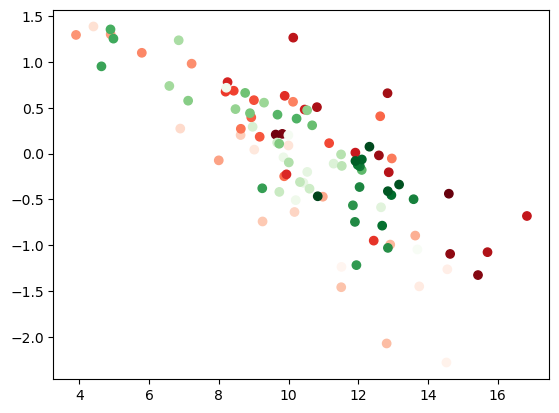

In [261]:
plt.scatter(averaged_omission_pc[0], averaged_omission_pc[1], c=averaged_omission_pc["index"], cmap='Reds')
plt.scatter(averaged_rewarded_pc[0], averaged_rewarded_pc[1], c=averaged_rewarded_pc["index"], cmap='Greens')

plt.show()

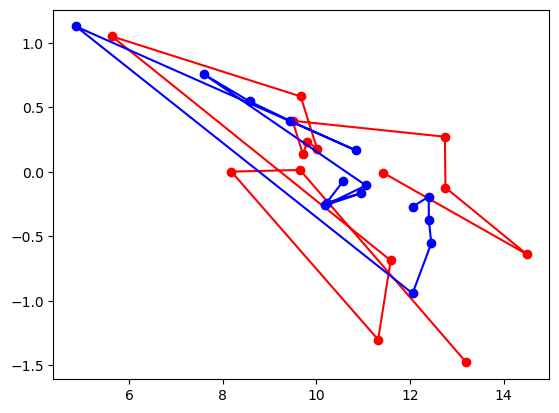

In [256]:
plt.plot(averaged_omission_pc[0], averaged_omission_pc[1], '-o', c="red")
plt.plot(averaged_rewarded_pc[0], averaged_rewarded_pc[1], '-o', c="blue")

plt.show()

In [263]:
all_categories = sorted(pc_product["rewarded_and_when"].unique())

In [264]:
all_categories

['-5s to 0s Omission',
 '-5s to 0s Rewarded',
 '0s to 5s Omission',
 '0s to 5s Rewarded',
 '5s to 10s Omission',
 '5s to 10s Rewarded']

In [265]:
all_colors = ["pink", "lightblue", "red", "cyan", "darkred", "darkcyan"]


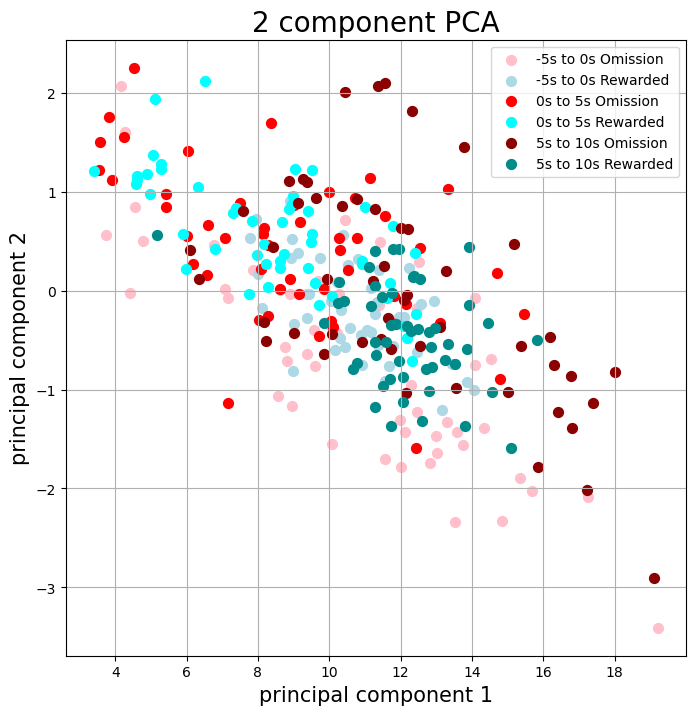

In [267]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = rewarded_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(all_categories, all_colors):
    indicesToKeep = pc_product['rewarded_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(all_categories)
ax.grid()

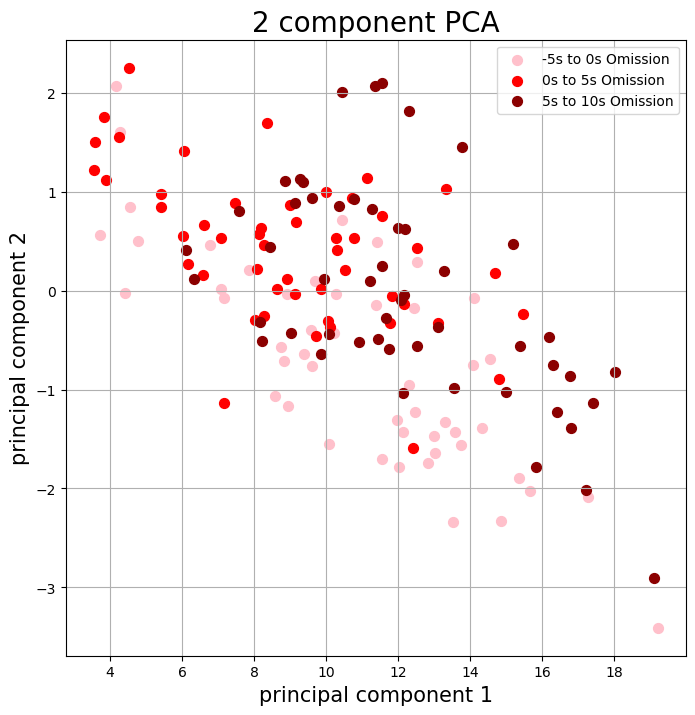

In [223]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["pink", "red", "darkred"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['rewarded_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

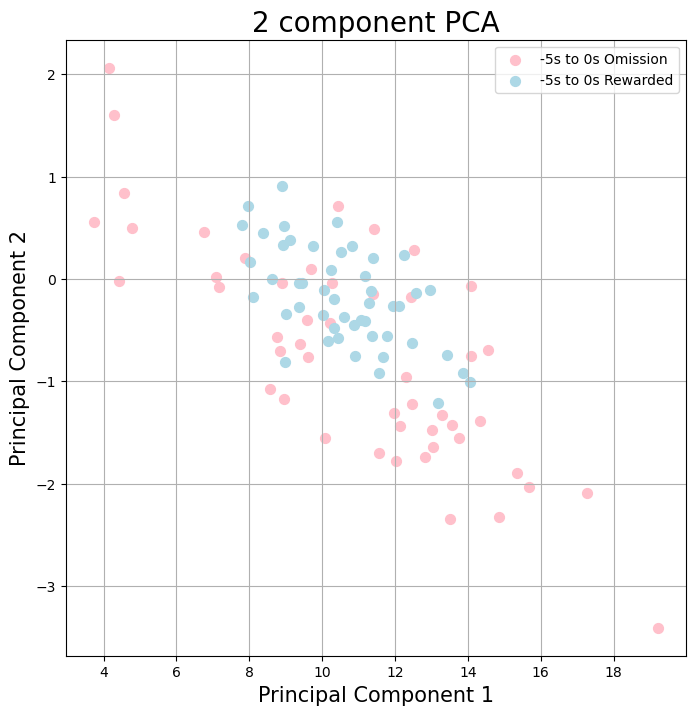

In [268]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['-5s to 0s Omission', '-5s to 0s Rewarded']
colors = ["pink", "lightblue"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['rewarded_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

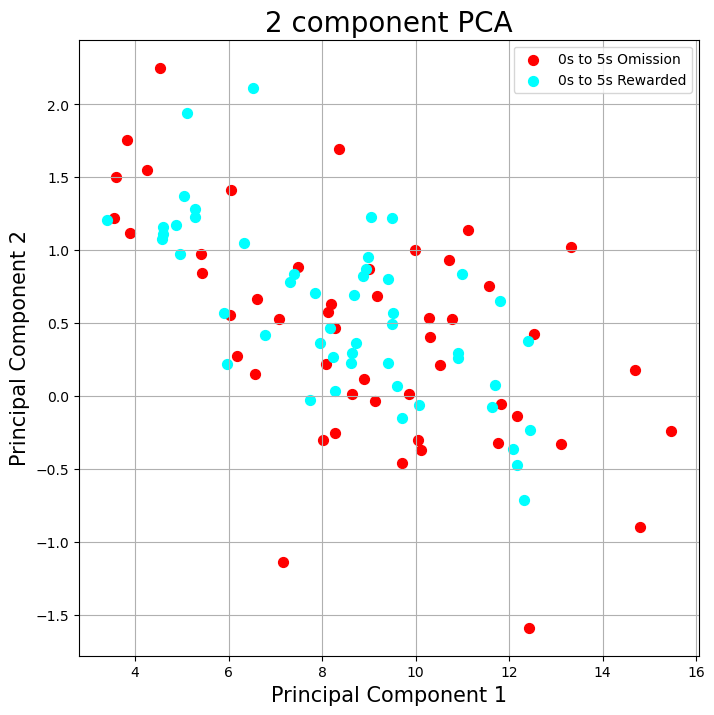

In [269]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0s to 5s Omission', '0s to 5s Rewarded']
colors = ["red", "cyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['rewarded_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

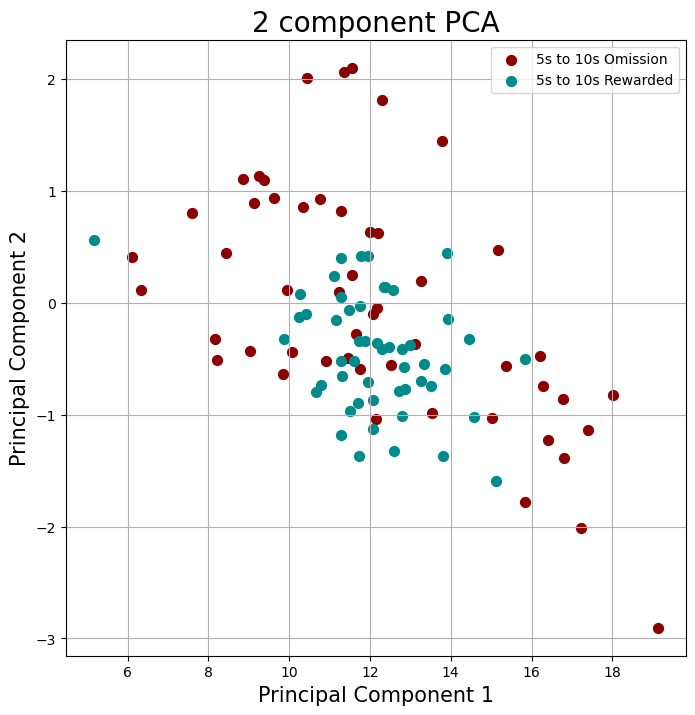

In [270]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['5s to 10s Omission', '5s to 10s Rewarded']
colors = ["darkred", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['rewarded_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [173]:
principal_df.shape

(14, 2)

In [176]:
firing_rate_and_pca_df = pd.concat([transposed_averaged_firing_rate_df.reset_index(), principal_df], axis=1)

In [177]:
firing_rate_and_pca_df

,"(index, )","(1, Omission)","(1, Rewarded)","(2, Omission)","(2, Rewarded)","(3, Omission)","(3, Rewarded)","(4, Omission)","(4, Rewarded)","(5, Omission)",...,"(147, Omission)","(147, Rewarded)","(148, Omission)","(148, Rewarded)","(149, Omission)","(149, Rewarded)","(150, Omission)","(150, Rewarded)",principal component 1,principal component 2
0,64,1.000000,1.272727,1.000000,1.545455,1.000000,1.636364,0.666667,1.909091,0.333333,...,2.000000,2.181818,2.000000,1.363636,2.000000,1.090909,2.333333,1.545455,23.046689,10.966681
1,53,0.000000,0.181818,0.000000,0.090909,0.000000,0.090909,0.000000,0.090909,0.000000,...,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11.066172,-1.512890
2,15,0.333333,0.181818,0.000000,0.272727,0.000000,0.000000,0.333333,0.636364,0.000000,...,0.333333,0.454545,0.000000,0.363636,0.000000,0.545455,0.333333,0.454545,4.182009,7.670974
3,6,0.666667,0.272727,0.000000,0.272727,0.333333,0.636364,0.000000,0.363636,0.333333,...,0.666667,0.818182,0.666667,1.090909,0.666667,0.818182,0.333333,1.000000,-0.140833,1.070498
4,71,1.000000,2.000000,1.666667,2.090909,1.666667,2.000000,1.666667,1.363636,4.000000,...,3.000000,1.454545,2.666667,1.090909,1.666667,1.090909,1.333333,1.636364,22.082930,-1.905248
5,79,2.333333,3.000000,3.333333,3.000000,3.000000,3.090909,3.333333,2.090909,4.666667,...,0.666667,3.000000,3.666667,2.272727,2.666667,2.727273,2.666667,2.545455,37.706254,-9.533119
6,48,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.272727,0.333333,...,0.000000,0.090909,0.000000,0.090909,0.000000,0.181818,0.000000,0.090909,-9.831633,-1.008882
7,73,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,-10.706443,-1.426370
8,55,0.666667,0.090909,0.666667,0.272727,0.333333,0.363636,0.333333,0.636364,0.333333,...,0.333333,0.636364,0.666667,0.363636,0.333333,0.545455,1.000000,0.727273,0.741351,2.195520
9,101,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,...,0.000000,0.090909,0.000000,0.272727,0.000000,0.000000,0.000000,0.000000,-10.499764,-1.074528


In [ ]:
firing_rate_and_pca_df

In [143]:
firing_rate_and_pca_df["before_during_after"] = firing_rate_and_pca_df["bin"].apply(lambda x: "-5s to 0s" if x < 50 else ("0s to 5s" if 50 <= x < 100 else "5s to 10s"))

In [144]:
firing_rate_and_pca_df["rewarded_and_when"] = firing_rate_and_pca_df.apply(lambda x: x["before_during_after"] + " " + x["rewarded_category"], axis=1)

In [145]:
firing_rate_and_pca_df

,bin,rewarded_category,index,64,53,15,6,71,79,48,...,12,83,10,4,tone_time,rewarded_bool,principal component 1,principal component 2,before_during_after,rewarded_and_when
0,1,Omission,1.416507e+07,1.000000,0.000000,0.333333,0.666667,1.000000,2.333333,0.000000,...,0.000000,0.000000,0.0,0.000000,1.416507e+07,0.0,0.223078,0.220430,-5s to 0s,-5s to 0s Omission
1,1,Rewarded,1.244992e+07,1.272727,0.181818,0.181818,0.272727,2.000000,3.000000,0.000000,...,0.000000,0.000000,0.0,0.090909,1.244992e+07,1.0,2.163308,1.660439,-5s to 0s,-5s to 0s Rewarded
2,2,Omission,1.416507e+07,1.000000,0.000000,0.000000,0.000000,1.666667,3.333333,0.000000,...,0.000000,0.000000,0.0,0.000000,1.416507e+07,0.0,1.955652,-0.003117,-5s to 0s,-5s to 0s Omission
3,2,Rewarded,1.244992e+07,1.545455,0.090909,0.272727,0.272727,2.090909,3.000000,0.000000,...,0.000000,0.090909,0.0,0.000000,1.244992e+07,1.0,1.910068,0.683119,-5s to 0s,-5s to 0s Rewarded
4,3,Omission,1.416507e+07,1.000000,0.000000,0.000000,0.333333,1.666667,3.000000,0.333333,...,0.000000,0.000000,0.0,0.000000,1.416507e+07,0.0,1.832778,-0.561062,-5s to 0s,-5s to 0s Omission
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,148,Rewarded,1.245007e+07,1.363636,0.000000,0.363636,1.090909,1.090909,2.272727,0.090909,...,0.000000,0.090909,0.0,0.000000,1.244992e+07,1.0,-0.261206,-0.423740,5s to 10s,5s to 10s Rewarded
296,149,Omission,1.416522e+07,2.000000,0.000000,0.000000,0.666667,1.666667,2.666667,0.000000,...,0.000000,0.000000,0.0,0.000000,1.416507e+07,0.0,1.500803,-0.588599,5s to 10s,5s to 10s Omission
297,149,Rewarded,1.245007e+07,1.090909,0.000000,0.545455,0.818182,1.090909,2.727273,0.181818,...,0.000000,0.090909,0.0,0.000000,1.244992e+07,1.0,0.178737,0.168610,5s to 10s,5s to 10s Rewarded
298,150,Omission,1.416522e+07,2.333333,0.000000,0.333333,0.333333,1.333333,2.666667,0.000000,...,0.000000,0.000000,0.0,0.000000,1.416507e+07,0.0,0.397052,-1.447816,5s to 10s,5s to 10s Omission


In [146]:
sorted(firing_rate_and_pca_df["rewarded_and_when"].unique())

['-5s to 0s Omission',
 '-5s to 0s Rewarded',
 '0s to 5s Omission',
 '0s to 5s Rewarded',
 '5s to 10s Omission',
 '5s to 10s Rewarded']

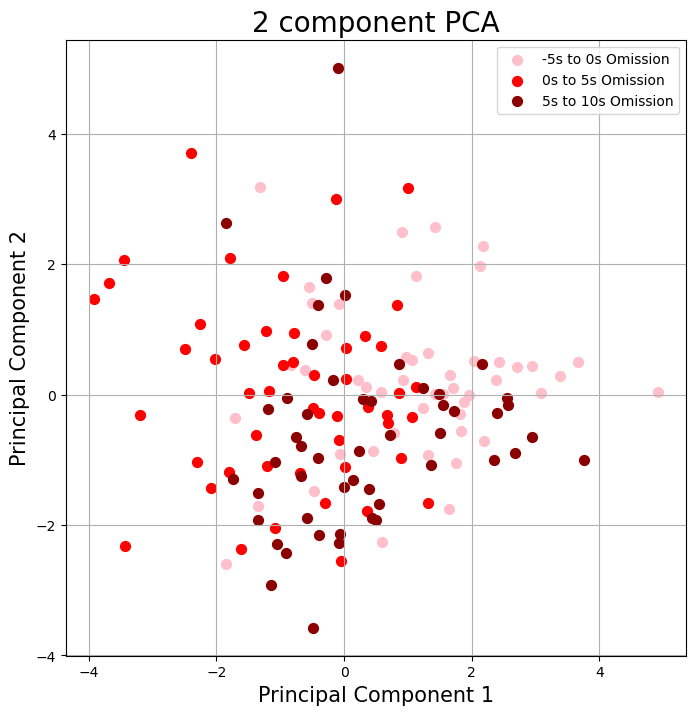

In [148]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["pink", "red", "darkred"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

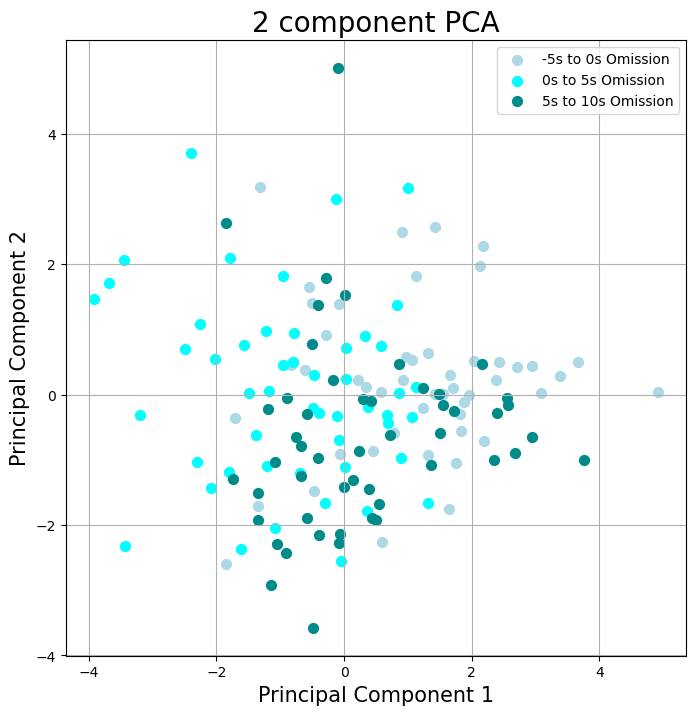

In [149]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [150]:
['-5s to 0s Omission',
 '-5s to 0s Rewarded',
 '0s to 5s Omission',
 '0s to 5s Rewarded',
 '5s to 10s Omission',
 '5s to 10s Rewarded']

['-5s to 0s Omission',
 '-5s to 0s Rewarded',
 '0s to 5s Omission',
 '0s to 5s Rewarded',
 '5s to 10s Omission',
 '5s to 10s Rewarded']

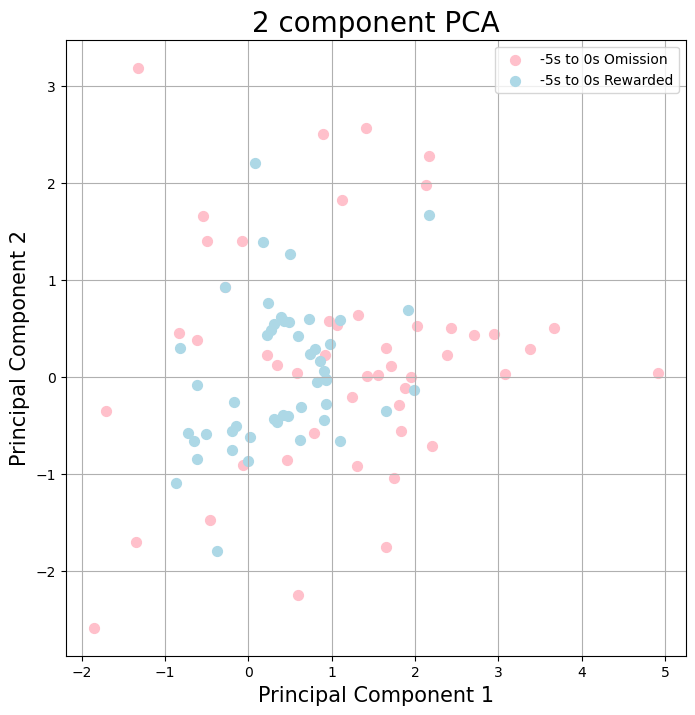

In [151]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['-5s to 0s Omission', '-5s to 0s Rewarded']
colors = ["pink", "lightblue"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

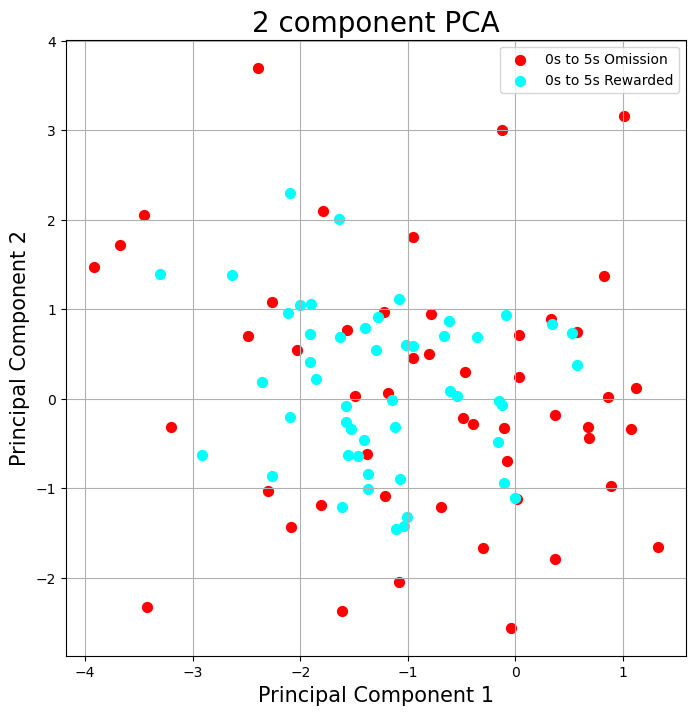

In [152]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0s to 5s Omission', '0s to 5s Rewarded']
colors = ["red", "cyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

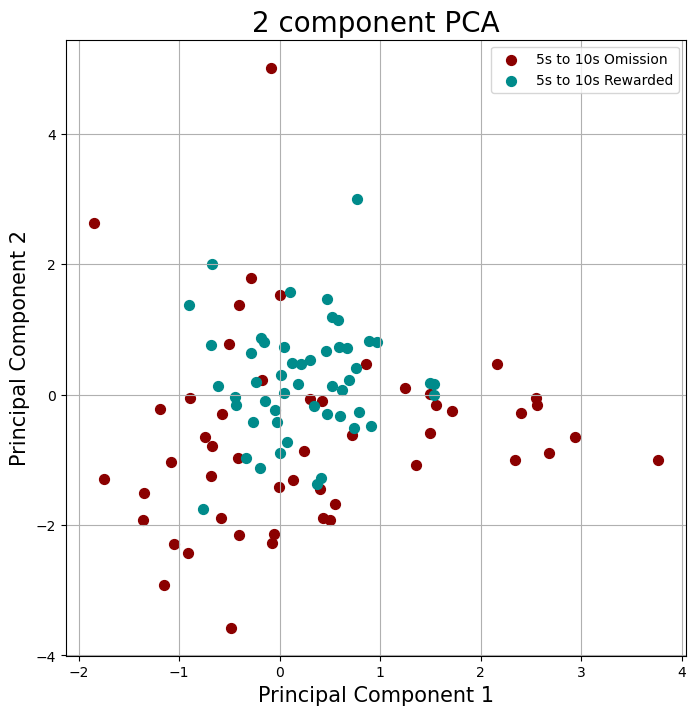

In [153]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['5s to 10s Omission', '5s to 10s Rewarded']
colors = ["darkred", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# PCA with Time Bin Rows

## Standarizing the Data

- TODO: Check why the 0s are being scaled differently

In [135]:
from sklearn.preprocessing import StandardScaler

In [136]:
# Separating out the features
x = resetted_averaged_firing_rate_array#.loc[:].values# Separating out the target
resetted_averaged_firing_rate_array = StandardScaler().fit_transform(x)

## Calculating the PCA

In [137]:
from sklearn.decomposition import PCA


In [138]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(resetted_averaged_firing_rate_array)
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [139]:
principal_df.head()

,principal component 1,principal component 2
0,0.223078,0.220430
1,2.163308,1.660439
2,1.955652,-0.003117
3,1.910068,0.683119
4,1.832778,-0.561062


In [140]:
principal_df.shape

(300, 2)

In [141]:
principal_df.shape

(300, 2)

In [142]:
firing_rate_and_pca_df = pd.concat([resetted_averaged_firing_rate_df, principal_df], axis=1)

In [143]:
firing_rate_and_pca_df["before_during_after"] = firing_rate_and_pca_df["bin"].apply(lambda x: "-5s to 0s" if x < 50 else ("0s to 5s" if 50 <= x < 100 else "5s to 10s"))

In [144]:
firing_rate_and_pca_df["rewarded_and_when"] = firing_rate_and_pca_df.apply(lambda x: x["before_during_after"] + " " + x["rewarded_category"], axis=1)

In [145]:
firing_rate_and_pca_df

,bin,rewarded_category,index,64,53,15,6,71,79,48,...,12,83,10,4,tone_time,rewarded_bool,principal component 1,principal component 2,before_during_after,rewarded_and_when
0,1,Omission,1.416507e+07,1.000000,0.000000,0.333333,0.666667,1.000000,2.333333,0.000000,...,0.000000,0.000000,0.0,0.000000,1.416507e+07,0.0,0.223078,0.220430,-5s to 0s,-5s to 0s Omission
1,1,Rewarded,1.244992e+07,1.272727,0.181818,0.181818,0.272727,2.000000,3.000000,0.000000,...,0.000000,0.000000,0.0,0.090909,1.244992e+07,1.0,2.163308,1.660439,-5s to 0s,-5s to 0s Rewarded
2,2,Omission,1.416507e+07,1.000000,0.000000,0.000000,0.000000,1.666667,3.333333,0.000000,...,0.000000,0.000000,0.0,0.000000,1.416507e+07,0.0,1.955652,-0.003117,-5s to 0s,-5s to 0s Omission
3,2,Rewarded,1.244992e+07,1.545455,0.090909,0.272727,0.272727,2.090909,3.000000,0.000000,...,0.000000,0.090909,0.0,0.000000,1.244992e+07,1.0,1.910068,0.683119,-5s to 0s,-5s to 0s Rewarded
4,3,Omission,1.416507e+07,1.000000,0.000000,0.000000,0.333333,1.666667,3.000000,0.333333,...,0.000000,0.000000,0.0,0.000000,1.416507e+07,0.0,1.832778,-0.561062,-5s to 0s,-5s to 0s Omission
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,148,Rewarded,1.245007e+07,1.363636,0.000000,0.363636,1.090909,1.090909,2.272727,0.090909,...,0.000000,0.090909,0.0,0.000000,1.244992e+07,1.0,-0.261206,-0.423740,5s to 10s,5s to 10s Rewarded
296,149,Omission,1.416522e+07,2.000000,0.000000,0.000000,0.666667,1.666667,2.666667,0.000000,...,0.000000,0.000000,0.0,0.000000,1.416507e+07,0.0,1.500803,-0.588599,5s to 10s,5s to 10s Omission
297,149,Rewarded,1.245007e+07,1.090909,0.000000,0.545455,0.818182,1.090909,2.727273,0.181818,...,0.000000,0.090909,0.0,0.000000,1.244992e+07,1.0,0.178737,0.168610,5s to 10s,5s to 10s Rewarded
298,150,Omission,1.416522e+07,2.333333,0.000000,0.333333,0.333333,1.333333,2.666667,0.000000,...,0.000000,0.000000,0.0,0.000000,1.416507e+07,0.0,0.397052,-1.447816,5s to 10s,5s to 10s Omission


In [146]:
sorted(firing_rate_and_pca_df["rewarded_and_when"].unique())

['-5s to 0s Omission',
 '-5s to 0s Rewarded',
 '0s to 5s Omission',
 '0s to 5s Rewarded',
 '5s to 10s Omission',
 '5s to 10s Rewarded']

In [147]:
omission_categories = [name for name in sorted(firing_rate_and_pca_df["rewarded_and_when"].unique()) if "Omission" in name]
rewarded_categories = [name for name in sorted(firing_rate_and_pca_df["rewarded_and_when"].unique()) if "Rewarded" in name]


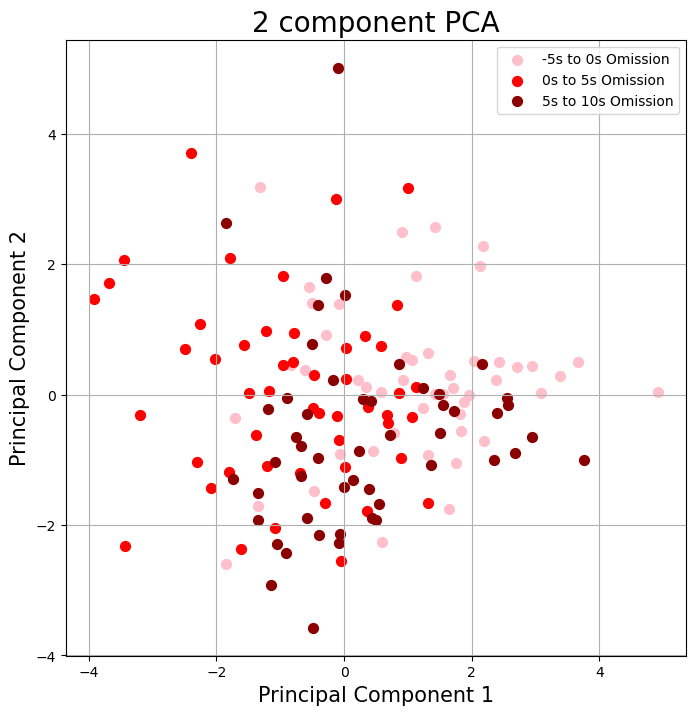

In [148]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["pink", "red", "darkred"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

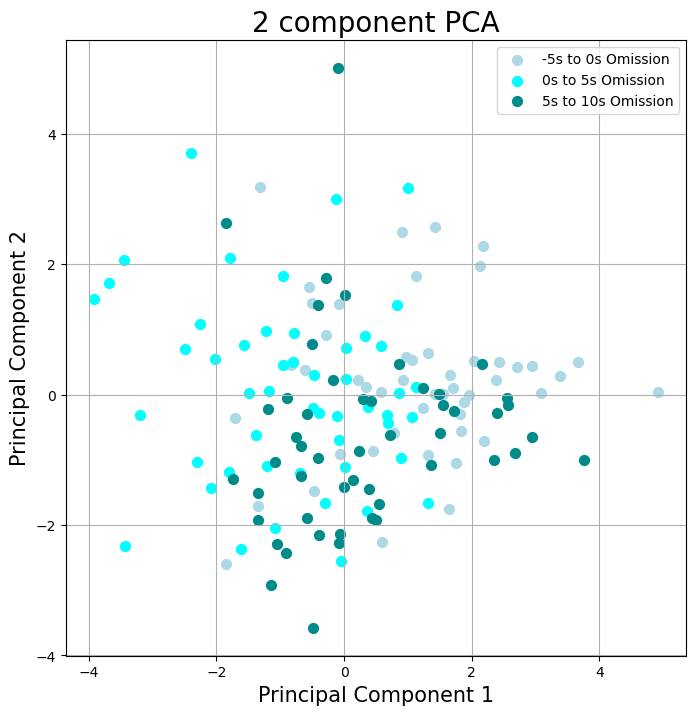

In [149]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [150]:
['-5s to 0s Omission',
 '-5s to 0s Rewarded',
 '0s to 5s Omission',
 '0s to 5s Rewarded',
 '5s to 10s Omission',
 '5s to 10s Rewarded']

['-5s to 0s Omission',
 '-5s to 0s Rewarded',
 '0s to 5s Omission',
 '0s to 5s Rewarded',
 '5s to 10s Omission',
 '5s to 10s Rewarded']

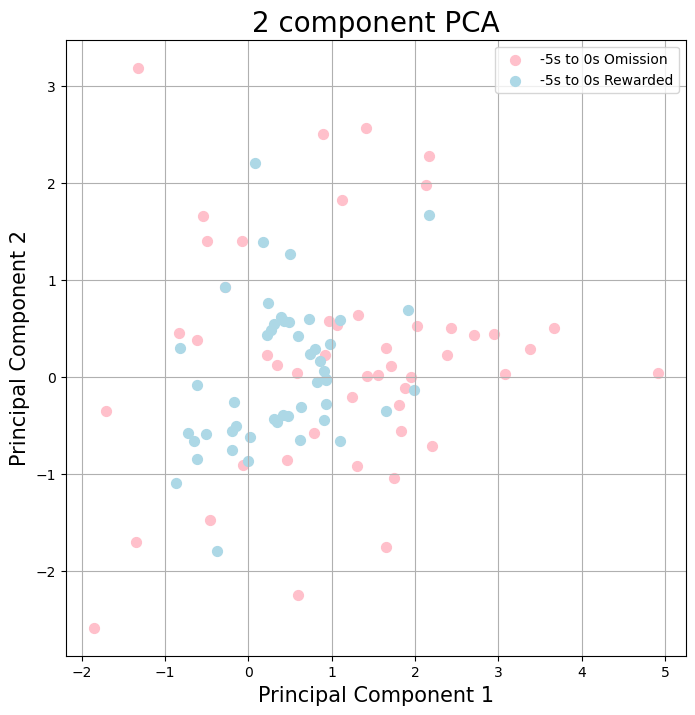

In [151]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['-5s to 0s Omission', '-5s to 0s Rewarded']
colors = ["pink", "lightblue"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

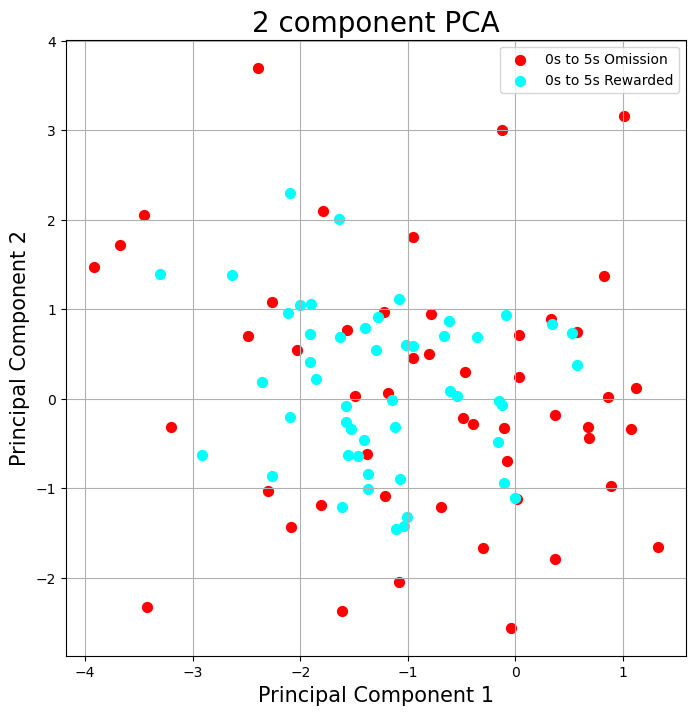

In [152]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0s to 5s Omission', '0s to 5s Rewarded']
colors = ["red", "cyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

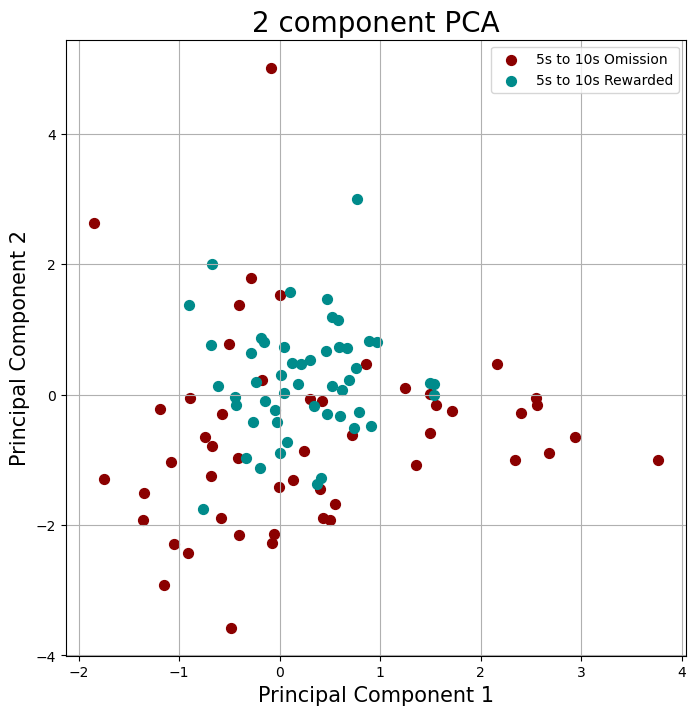

In [153]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['5s to 10s Omission', '5s to 10s Rewarded']
colors = ["darkred", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [154]:
raise ValueError()

ValueError: 

# From DIN to Video

- State 1 is when the MED-PC signal is being recieved. And 0 is when it is turned off. So we will get the timestamp of when it is first 1.

In [ ]:
DIN_state_array

In [ ]:
DIN_time_stamp = DIN_state_array[5][0]

In [ ]:
DIN_time_stamp

In [ ]:
good_unit_bins = np.digitize(good_unit_times, all_tone_unit_time, right=True)

- Array of the time stamp of all the frames

In [ ]:
[1431775 + num * 2000 for num in range(-50, 50)]

In [ ]:
len(within_interval_unit_times)

In [ ]:
range(1431775, 

In [ ]:
[1431775 + num * 2000 for num in range(50)]

In [ ]:
[(1431775 - (num + 1) * 2000, 1431775 - num * 2000) for num in range(50)][::-1]

In [ ]:
(4003716 - 3772337) / 20000

In [ ]:
(5204112 - 4003716) / 20000 

In [ ]:
(5404109 - 5204112) / 20000

In [ ]:
(6804107 - 5404109) / 20000

In [ ]:
3772337/20000/3600*60

In [ ]:
pos_timestamp_array

- Getting the first video time stamp that is greater than the voltage time stamp

In [ ]:
current_video_frame = timestamp_to_index(current_ts=DIN_time_stamp, ts_array=pos_timestamp_array)

In [ ]:
current_video_frame

## Getting the specific frame

In [ ]:
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('Frame count:', frame_count)

- Original frame number(before light turns on)

In [ ]:
corrected_video_frame = current_video_frame

- Corrected frame number(that has the light on)

In [ ]:
corrected_video_frame = current_video_frame + 2

In [ ]:
cap.set(cv2.CAP_PROP_POS_FRAMES, corrected_video_frame)


In [ ]:
_, frame = cap.read()

In [ ]:
video_file_path

In [ ]:
output_directory = "./proc"

In [ ]:
output_directory

In [ ]:
os.makedirs(output_directory, exist_ok=True)

In [ ]:
video_file_basename = os.path.basename(video_file_path)

In [ ]:
video_file_root = os.path.splitext(video_file_basename)[0]

In [ ]:
video_file_root

In [ ]:
cv2.imwrite(os.path.join(output_directory, '{}.frame_{}.png'.format(video_file_root, corrected_video_frame)), frame)

- Where this video time stamp is(within the list of video time stamps), would be the frame number that corresponds to the ephys recording instance

In [ ]:
current_video_seconds = corrected_video_frame / fps

In [ ]:
current_video_seconds

In [ ]:
print("MED-PC signal is at {}:{}".format(int(current_video_seconds // 60), int(current_video_seconds % 60)))

# Syncing up the timestamps using Pandas

## Adding the Voltage as columns

In [ ]:
voltage_timestamp_array[:5]

In [ ]:
voltage_timestamp_array.shape

In [ ]:
voltage_value_array[:5]

In [ ]:
voltage_value_array.shape

- Adding the voltage timestamps

In [ ]:
ephys_dataframe = pd.DataFrame(voltage_timestamp_array, columns=["voltage_time_stamp"])

In [ ]:
ephys_dataframe.head()

- Adding the voltage value

In [ ]:
ephys_dataframe["voltage_value"] = voltage_value_array.tolist()

In [ ]:
ephys_dataframe.head()

## Adding the video data as columns

- Creating a seperate dataframe for video data first

In [ ]:
video_time_stamp_dict["data"][:5]

In [ ]:
video_time_stamp_dict["data"][-5:]

In [ ]:
video_dataframe = pd.DataFrame(video_time_stamp_dict["data"])

In [ ]:
video_dataframe.head()

- Adding the frames which would just be the number in the list that the timestamps belongs to

In [ ]:
video_dataframe.insert(0, 'frame_number', range(1, 1 + len(video_dataframe)))

- Calculating the time within the video by dividing the frame by the fps

In [ ]:
video_dataframe["video_time"] = video_dataframe["frame_number"] / fps

In [ ]:
video_dataframe["video_seconds"] = video_dataframe["video_time"].astype(int)

In [ ]:
video_dataframe

## Combining the ephys and video dataframe into one

In [ ]:
ephy_and_video_dataframe = pd.merge(ephys_dataframe, video_dataframe, left_on='voltage_time_stamp', right_on='PosTimestamp', how="left")

In [ ]:
ephy_and_video_dataframe

In [ ]:
ephy_and_video_dataframe.columns

- There are only a small number of rows that have information for the video, because the sampling rate is much smaller. 

In [ ]:
ephy_and_video_dataframe.dropna(subset=["PosTimestamp"])

- Filling in all the blank cells with the previous rows for the video related columns into new columns. This can be used to select for all rows that correspond to something happening within the video

In [ ]:
ephy_and_video_dataframe['filled_PosTimestamp'] = ephy_and_video_dataframe['PosTimestamp'].fillna(method='ffill')
ephy_and_video_dataframe['filledHWframeCount'] = ephy_and_video_dataframe['HWframeCount'].fillna(method='ffill')
ephy_and_video_dataframe['filled_frame_number'] = ephy_and_video_dataframe['frame_number'].fillna(method='ffill')
ephy_and_video_dataframe['filled_video_time'] = ephy_and_video_dataframe['video_time'].fillna(method='ffill')
ephy_and_video_dataframe['filled_video_seconds'] = ephy_and_video_dataframe['video_seconds'].fillna(method='ffill')

In [ ]:
ephy_and_video_dataframe.tail()

## Adding the DIN info

In [ ]:
DIN_dataframe = pd.DataFrame(DIN_state_array)

In [ ]:
DIN_dataframe["trial_number"] = DIN_dataframe["state"].cumsum()

In [ ]:
DIN_dataframe

In [ ]:
ephy_and_video_dataframe = pd.merge(ephy_and_video_dataframe, DIN_dataframe, left_on='voltage_time_stamp', right_on='time', how="left")


In [ ]:
ephy_and_video_dataframe.head()

In [ ]:
ephy_and_video_dataframe.dropna(subset=["time"])

In [ ]:
ephy_and_video_dataframe["filled_state"] = ephy_and_video_dataframe["state"].ffill()
ephy_and_video_dataframe["filled_trial_number"] = ephy_and_video_dataframe["trial_number"].ffill()

In [ ]:
ephy_and_video_dataframe.head()

In [ ]:
ephy_and_video_dataframe.tail()

In [ ]:
trial_1_df = ephy_and_video_dataframe[ephy_and_video_dataframe["filled_trial_number"] == 2]

In [ ]:
trial_1_df.head()

- Original frame number(before light turns on)

In [ ]:
current_video_frame = trial_1_df["filled_frame_number"].min()

- Corrected frame number(that has the light on)

In [ ]:
corrected_video_frame = current_video_frame + 2

In [ ]:
cap.set(cv2.CAP_PROP_POS_FRAMES, corrected_video_frame)


In [ ]:
_, frame = cap.read()

In [ ]:
video_file_path

In [ ]:
output_directory = "./proc"

In [ ]:
output_directory

In [ ]:
os.makedirs(output_directory, exist_ok=True)

In [ ]:
video_file_basename = os.path.basename(video_file_path)

In [ ]:
video_file_root = os.path.splitext(video_file_basename)[0]

In [ ]:
video_file_root

In [ ]:
cv2.imwrite(os.path.join(output_directory, '{}.frame_{}.png'.format(video_file_root, corrected_video_frame)), frame)